In [1]:
# %reset

# Library imports

In [2]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

%matplotlib inline

from Bio.Seq import Seq
import xlsxwriter

# Data import

In [3]:
# data from 03 feb '22
df1 = pd.read_csv("../raw_data/03_feb_22/20220203_kumar_file1.csv")
df2 = pd.read_csv("../raw_data/03_feb_22/20220203_kumar_file2.csv")
df3 = pd.read_csv("../raw_data/03_feb_22/20220203_kumar_file3.csv")

nseqs = len(df3.index)
print(f"Total number of SARS-CoV-2 sequnces analyzed by CovidCG: {nseqs}")

print()
print(df1.head())
print()
print(df2.head())
print()
print(df3.head())

Total number of SARS-CoV-2 sequnces analyzed by CovidCG: 6392612

           collection_date mutation_name mutation_str    pos ref alt  count
0  2019-12-24 00:00:00.000        T8987A     8987|T|A   8987   T   A      1
1  2019-12-26 00:00:00.000        C6968A     6968|C|A   6968   C   A      1
2  2019-12-30 00:00:00.000       G20670A    20670|G|A  20670   G   A      1
3  2019-12-30 00:00:00.000       A24325G    24325|A|G  24325   A   G      4
4  2019-12-30 00:00:00.000        G7016A     7016|G|A   7016   G   A      1

  mutation_name mutation_str    pos ref alt    count  fraction
0       A23403G    23403|A|G  23403   A   G  6353058  0.993813
1        C3037T     3037|C|T   3037   C   T  6340128  0.991790
2       C14408T    14408|C|T  14408   C   T  6339142  0.991636
3         C241T      241|C|T    241   C   T  6323298  0.989157
4       A28271-    28271|A|-  28271   A   -  4327910  0.677017

     Accession ID          collection_date
0  EPI_ISL_434534  2019-12-30 00:00:00.000
1  EPI_ISL_4

In [4]:
df_primers = pd.read_csv("../seq_data_files/pmc7865767_table02.csv")
df_primers.head()

,Source,Primer/Probe Name,Target Gene,Sequence,Length,Genomic Region
0,"China CDC, China",Forward (F),ORF1ab,CCCTGTGGGTTTTACACTTAA,21,"13,342–13,362"
1,"China CDC, China",Reverse (R),ORF1ab,ACGATTGTGCATCAGCTGA,19,"13,442–13,460"
2,"China CDC, China",Fluorescence probe (P),ORF1ab,CCGTCTGCGGTATGTGGAAAGGTTATGG,28,"13,377–13,404"
3,"China CDC, China",Forward (F),N,GGGGAACTTCTCCTGCTAGAAT,22,"28,881–28,902"
4,"China CDC, China",Reverse (R),N,CAGACATTTTGCTCTCAAGCTG,22,"28,958–28,979"


NIID's sequences were found at a left-shift of 17 NTs in the reference sequence. Corrections in NIID's  primer/probe set are done in the code block below.

NIID- National Institute of Infectious Diseases, Japan

In [5]:
# Corrections in NIID's primer/probe set
df_primers.at[
    df_primers[df_primers["Primer/Probe Name"] == "NIID_2019-nCOV_N_F2"].index[0],
    "Genomic Region",
] = "29,125–29,144"


df_primers.at[
    df_primers[df_primers["Primer/Probe Name"] == "NIID_2019-nCOV_N_R2"].index[0],
    "Genomic Region",
] = "29,263–29,282"
df_primers.at[
    df_primers[df_primers["Primer/Probe Name"] == "NIID_2019-nCOV_N_R2"].index[0],
    "Sequence",
] = "TGGCACCTGTGTAGGTCAAC"


df_primers.at[
    df_primers[df_primers["Primer/Probe Name"] == "NIID_2019-nCOV_N_P2"].index[0],
    "Genomic Region",
] = "29,222–29,241"


df_primers

,Source,Primer/Probe Name,Target Gene,Sequence,Length,Genomic Region
0,"China CDC, China",Forward (F),ORF1ab,CCCTGTGGGTTTTACACTTAA,21,"13,342–13,362"
1,"China CDC, China",Reverse (R),ORF1ab,ACGATTGTGCATCAGCTGA,19,"13,442–13,460"
2,"China CDC, China",Fluorescence probe (P),ORF1ab,CCGTCTGCGGTATGTGGAAAGGTTATGG,28,"13,377–13,404"
3,"China CDC, China",Forward (F),N,GGGGAACTTCTCCTGCTAGAAT,22,"28,881–28,902"
4,"China CDC, China",Reverse (R),N,CAGACATTTTGCTCTCAAGCTG,22,"28,958–28,979"
5,"China CDC, China",Fluorescence probe (P),N,TTGCTGCTGCTTGACAGATT,20,"28,934–28,953"
6,"Institut Pasteur, France",nCoV_IP2-12669Fw,RdRp,ATGAGCTTAGTCCTGTTG,18,"12,690–12,707"
7,"Institut Pasteur, France",nCoV_IP2-12759Rv,RdRp,CTCCCTTTGTTGTGTTGT,18,"12,780–12,797"
8,"Institut Pasteur, France",nCoV_IP2-12696bProbe(+),RdRp,ATGTCTTGTGCTGCCGGTA,19,"12,719–12,737"
9,"Institut Pasteur, France",nCoV_IP4-14059Fw,RdRp,GGTAACTGGTATGATTTCG,19,"14,080–14,098"


## SARS-CoV-2 annotation (acc to NCBI)

In [6]:
sars_cov_2_genome = {
    (1, 265): "5'-UTR",
    (266, 21555): "ORF1ab",
    (21563, 25384): "S",
    (25393, 26220): "ORF3a",
    (26245, 26472): "E",
    (26523, 27191): "M",
    (27202, 27387): "ORF6",
    (27394, 27759): "ORF7a",
    (27756, 27887): "ORF7b",
    (27894, 28259): "ORF8",
    (28274, 29533): "N",
    (29558, 29674): "ORF10",
    (29675, 29903): "3'-UTR",
}

sars_cov_2_genome

{(1, 265): "5'-UTR",
 (266, 21555): 'ORF1ab',
 (21563, 25384): 'S',
 (25393, 26220): 'ORF3a',
 (26245, 26472): 'E',
 (26523, 27191): 'M',
 (27202, 27387): 'ORF6',
 (27394, 27759): 'ORF7a',
 (27756, 27887): 'ORF7b',
 (27894, 28259): 'ORF8',
 (28274, 29533): 'N',
 (29558, 29674): 'ORF10',
 (29675, 29903): "3'-UTR"}

# Data Analysis

In [7]:
df_primers["start_pos"], df_primers["end_pos"] = 0, 0

for row in df_primers.itertuples():
    start, end = row._6.split("–")
    start, end = int(start.replace(",", "")), int(end.replace(",", ""))
    df_primers.at[row.Index, "start_pos"] = int(start)
    df_primers.at[row.Index, "end_pos"] = int(end)

df_primers.head()

,Source,Primer/Probe Name,Target Gene,Sequence,Length,Genomic Region,start_pos,end_pos
0,"China CDC, China",Forward (F),ORF1ab,CCCTGTGGGTTTTACACTTAA,21,"13,342–13,362",13342,13362
1,"China CDC, China",Reverse (R),ORF1ab,ACGATTGTGCATCAGCTGA,19,"13,442–13,460",13442,13460
2,"China CDC, China",Fluorescence probe (P),ORF1ab,CCGTCTGCGGTATGTGGAAAGGTTATGG,28,"13,377–13,404",13377,13404
3,"China CDC, China",Forward (F),N,GGGGAACTTCTCCTGCTAGAAT,22,"28,881–28,902",28881,28902
4,"China CDC, China",Reverse (R),N,CAGACATTTTGCTCTCAAGCTG,22,"28,958–28,979",28958,28979


In [8]:
# sorting the dataframe by collection date in ascending order
df1.sort_values(by="collection_date", inplace=True)

# keeping only the first entry for each mutation,
# hence, revealing the first occurence of each mutation
df1.drop_duplicates(
    subset=["mutation_str"], keep="first", inplace=True, ignore_index=True
)

# df1, df2 only have unique mutations by now and
# must have equal lengths
print("Do both dfs have equal length?: " f"{len(df1.index) == len(df2.index)}")

Do both dfs have equal length?: True


In [9]:
# Creating copies to work with; preserving the raw data
fil_df1 = df1.copy()
fil_df2 = df2.copy()

# Count column of first dataframe is useless as that
# corresponds to the count of that mutation on a particular
# date i.e., date of first occurrence of the mutation
del fil_df1["count"]

# arranging fil_df1 and fil_df2 so that each of their
# entry matches in order
fil_df1.sort_values(by="mutation_name", inplace=True)
fil_df2.sort_values(by="mutation_name", inplace=True)

# To avoid any complications because of
# index mismatch/index clash later on
fil_df1.reset_index(drop=True, inplace=True)
fil_df2.reset_index(drop=True, inplace=True)

# Check if all rows for mutation_name are same for both dfs or not
flag = fil_df1["mutation_name"].equals(fil_df2["mutation_name"])
print("Are all rows for mutation_name same in both fil_dfs?: " f"{flag}")

Are all rows for mutation_name same in both fil_dfs?: True


In [10]:
# Creating a master dataframe and removing any duplicated columns
df = pd.concat([fil_df1, fil_df2], axis=1)
df = df.loc[:, ~df.columns.duplicated()]

In [11]:
# Adding the percentage abundance column
df["per_abundance"] = df["fraction"].multiply(100)

# Renaming the troubling columns
# because count is a python function as well and it
# may cause complications later on
# e.g., calling it as df.count.nsmallest(1) will
# give us attribute error
df.rename(columns={"count": "count_of_seqs"}, inplace=True)

# to convert collection date column to pandas datetime format
df["collection_date"] = pd.to_datetime(
    df["collection_date"], format="%Y-%m-%d %H:%M:%S.%f"
)
df3["collection_date"] = pd.to_datetime(
    df3["collection_date"], format="%Y-%m-%d %H:%M:%S.%f"
)

print("This should be a pandas Timestamp: " f"{type(df.collection_date[0])}")

This should be a pandas Timestamp: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [12]:
# Removing any mutations containing 'N' from the dataframe
df = df[~(df.mutation_name.str.contains("N+", regex=True))]

df.reset_index(drop=True, inplace=True)

In [13]:
# Creating a copy of master dataframe to work with;
# preserving the master dataframe
DF = df.copy()
DF.sort_values(by="count_of_seqs", inplace=True, ascending=False)
DF.reset_index(drop=True, inplace=True)

print(
    f"(Initially)Length of the master dataframe is: {len(DF.index)};"
    f" Smallest count is {DF.count_of_seqs.min()}"
)

(Initially)Length of the master dataframe is: 81756; Smallest count is 1


- (https://stackoverflow.com/questions/8327705/what-are-and-in-regular-expressions)

In [14]:
# To get substitutions, deletions and insertions
substitutions = DF[~(DF.ref.str.contains("-") | DF.alt.str.contains("-"))]
print(f"#Substitutions: {len(substitutions.index)}")

deletions = DF[DF.alt.str.contains("-")]
print(f"#Deletions: {len(deletions.index)}")

insertions = DF[DF.ref.str.contains("-")]
print(f"#Insertions: {len(insertions.index)}")


substitutions.reset_index(drop=True, inplace=True)
deletions.reset_index(drop=True, inplace=True)
insertions.reset_index(drop=True, inplace=True)

#Substitutions: 67503
#Deletions: 9646
#Insertions: 4607


In [15]:
# >=0.1%
df_per_pt1 = DF[DF["per_abundance"] >= 0.1]
df_per_pt1.reset_index(drop=True, inplace=True)

df_per_pt1_subs = substitutions[substitutions["per_abundance"] >= 0.1]
df_per_pt1_dels = deletions[deletions["per_abundance"] >= 0.1]
df_per_pt1_ins = insertions[insertions["per_abundance"] >= 0.1]

print("For Mutations >= 0.1%")
print(
    f"Length of dataframe is: {len(df_per_pt1.index)};\n"
    f"Smallest count is {df_per_pt1.count_of_seqs.min()}"
)
print(f"#Substitutions: {len(df_per_pt1_subs.index)}")
print(f"#Deletions: {len(df_per_pt1_dels.index)}")
print(f"#Insertions: {len(df_per_pt1_ins.index)}")
print()

df_per_pt1_subs.reset_index(drop=True, inplace=True)
df_per_pt1_dels.reset_index(drop=True, inplace=True)
df_per_pt1_ins.reset_index(drop=True, inplace=True)

df_per_pt1_subs.name = "subs_pt1per"
df_per_pt1_dels.name = "dels_pt1per"
df_per_pt1_ins.name = "ins_pt1per"


# -----------------------------------------------------------------------


# >=0.05%
df_per_pt05 = DF[DF["per_abundance"] >= 0.05]
df_per_pt05.reset_index(drop=True, inplace=True)

df_per_pt05_subs = substitutions[substitutions["per_abundance"] >= 0.05]
df_per_pt05_dels = deletions[deletions["per_abundance"] >= 0.05]
df_per_pt05_ins = insertions[insertions["per_abundance"] >= 0.05]

print("For Mutations >= 0.05%")
print(
    f"Length of dataframe is: {len(df_per_pt05.index)};\n"
    f"Smallest count is {df_per_pt05.count_of_seqs.min()}"
)
print(f"#Substitutions: {len(df_per_pt05_subs.index)}")
print(f"#Deletions: {len(df_per_pt05_dels.index)}")
print(f"#Insertions: {len(df_per_pt05_ins.index)}")
print()

df_per_pt05_subs.reset_index(drop=True, inplace=True)
df_per_pt05_dels.reset_index(drop=True, inplace=True)
df_per_pt05_ins.reset_index(drop=True, inplace=True)

df_per_pt05_subs.name = "subs_pt05per"
df_per_pt05_dels.name = "dels_pt05per"
df_per_pt05_ins.name = "ins_pt05per"


# -----------------------------------------------------------------------


# >=0.02%
df_per_pt02 = DF[DF["per_abundance"] >= 0.02]
df_per_pt02.reset_index(drop=True, inplace=True)

df_per_pt02_subs = substitutions[substitutions["per_abundance"] >= 0.02]
df_per_pt02_dels = deletions[deletions["per_abundance"] >= 0.02]
df_per_pt02_ins = insertions[insertions["per_abundance"] >= 0.02]

print("For Mutations >= 0.02%")
print(
    f"Length of dataframe is: {len(df_per_pt02.index)};\n"
    f"Smallest count is {df_per_pt02.count_of_seqs.min()}"
)
print(f"#Substitutions: {len(df_per_pt02_subs.index)}")
print(f"#Deletions: {len(df_per_pt02_dels.index)}")
print(f"#Insertions: {len(df_per_pt02_ins.index)}")
print()

df_per_pt02_subs.reset_index(drop=True, inplace=True)
df_per_pt02_dels.reset_index(drop=True, inplace=True)
df_per_pt02_ins.reset_index(drop=True, inplace=True)

df_per_pt02_subs.name = "subs_pt02per"
df_per_pt02_dels.name = "dels_pt02per"
df_per_pt02_ins.name = "ins_pt02per"


# -----------------------------------------------------------------------


# >0.01%
df_per_pt01 = DF[DF["per_abundance"] >= 0.01]
df_per_pt01.reset_index(drop=True, inplace=True)

df_per_pt01_subs = substitutions[substitutions["per_abundance"] >= 0.01]
df_per_pt01_dels = deletions[deletions["per_abundance"] >= 0.01]
df_per_pt01_ins = insertions[insertions["per_abundance"] >= 0.01]

print(r"For Mutations >= 0.01%")
print(
    f"Length of dataframe is: {len(df_per_pt01.index)};\n"
    f"Smallest count is {df_per_pt01.count_of_seqs.min()}"
)
print(f"#Substitutions: {len(df_per_pt01_subs.index)}")
print(f"#Deletions: {len(df_per_pt01_dels.index)}")
print(f"#Insertions: {len(df_per_pt01_ins.index)}")
print()

df_per_pt01_subs.reset_index(drop=True, inplace=True)
df_per_pt01_dels.reset_index(drop=True, inplace=True)
df_per_pt01_ins.reset_index(drop=True, inplace=True)

df_per_pt01_subs.name = "subs_pt01per"
df_per_pt01_dels.name = "dels_pt01per"
df_per_pt01_ins.name = "ins_pt01per"

For Mutations >= 0.1%
Length of dataframe is: 1821;
Smallest count is 6393
#Substitutions: 1777
#Deletions: 32
#Insertions: 12

For Mutations >= 0.05%
Length of dataframe is: 3072;
Smallest count is 3197
#Substitutions: 2993
#Deletions: 56
#Insertions: 23

For Mutations >= 0.02%
Length of dataframe is: 6024;
Smallest count is 1279
#Substitutions: 5874
#Deletions: 107
#Insertions: 43

For Mutations >= 0.01%
Length of dataframe is: 9854;
Smallest count is 640
#Substitutions: 9594
#Deletions: 187
#Insertions: 73



We reasoned about the differences between supplying two types of dataframes as an input to unique position calculations done ahead:
1. Taking the summation of all the mutations occuring at one position and then setting the cutoffs based on mutation abundances
2. Using the sorted dataframe(descending order in terms of mutation abundance) to keep only the unique positions. In our sorted dataframe, each position had multiple entries. Mutation abundance cutoffs were then set on the unique positions data obtained in the last step.

Way 2 was better because it takes into account only the mutation abundance numbers which are actually useful unlike Way 1. e.g., In Way 1, say we have two mutations at position _x_ with mutation abundance 0.06% each. Given we are interested in mutations with mutation abundance >=0.1%, none of these mutations are good enough for our consideration hence this position _x_ should be considered conserved. But if we go with Way 1, then the summation of mutation abundances for the mutations at position _x_ >=0.1 and hence it will not be counted as a conserved position which will be an error.

In [16]:
SARS_COV_2_GENOME_RANGE = range(1, 29904)

In [17]:
# Keeping only the first entry for each unique position,
# i.e., the entry for each position with the largest
# count/fraction/per_abundance or we can say that only
# most prevalent mutation for each position is kept
unique_pos = DF.drop_duplicates(
    subset=["pos"], keep="first", inplace=False, ignore_index=True
)
unique_pos = unique_pos.sort_values(by="count_of_seqs", ascending=False).reset_index(
    drop=True
)

print(
    f"Largest position entry in our original raw dataframe 1 is "
    f"{(df1.pos.nlargest(1)).to_string(index=False)}"
)

series_SARS_COV_2_GENOME_RANGE = pd.Series(SARS_COV_2_GENOME_RANGE)

Largest position entry in our original raw dataframe 1 is 29903


In [18]:
# -----------------------------------------------------------------------------------
# -------- Generating multiple series having some of the positions excluded ---------
# -------- from genome range based on some exclusion criteria set according to ------
# -------- abundance of the mutations occuring at those positions -------------------
# -----------------------------------------------------------------------------------


# Series with positions having no mutations in all the sequences analyzed
no_mutation_at_all = series_SARS_COV_2_GENOME_RANGE[
    ~series_SARS_COV_2_GENOME_RANGE.isin(unique_pos.pos)
]
no_mutation_at_all.sort_values(inplace=True)
no_mutation_at_all.reset_index(inplace=True, drop=True)
print(
    "Positions having no mutations in all the sequences analyzed: "
    f"\n{no_mutation_at_all}\n"
)


# -----------------------------------------------------------------------------------


# Excluding only the Positions having mutations with >=0.1% abundance
no_mutation_geq_pt1per = series_SARS_COV_2_GENOME_RANGE[
    ~series_SARS_COV_2_GENOME_RANGE.isin(
        unique_pos.pos[unique_pos["per_abundance"] >= 0.1]
    )
]
no_mutation_geq_pt1per.sort_values(inplace=True)
no_mutation_geq_pt1per.reset_index(inplace=True, drop=True)
print(
    "Excluding only the Positions having mutations with >=0.1% abundance: "
    f"\n{no_mutation_geq_pt1per}\n"
)


# -----------------------------------------------------------------------------------


# Excluding only the Positions having mutations with >=0.05% abundance
no_mutation_geq_pt05per = series_SARS_COV_2_GENOME_RANGE[
    ~series_SARS_COV_2_GENOME_RANGE.isin(
        unique_pos.pos[unique_pos["per_abundance"] >= 0.05]
    )
]
no_mutation_geq_pt05per.sort_values(inplace=True)
no_mutation_geq_pt05per.reset_index(inplace=True, drop=True)
print(
    f"Excluding only the Positions having mutations with >=0.05% abundance: "
    f"\n{no_mutation_geq_pt05per}\n"
)


# -----------------------------------------------------------------------------------


# Excluding only the Positions having mutations with >=0.01% abundance
no_mutation_geq_pt01per = series_SARS_COV_2_GENOME_RANGE[
    ~series_SARS_COV_2_GENOME_RANGE.isin(
        unique_pos.pos[unique_pos["per_abundance"] >= 0.01]
    )
]
no_mutation_geq_pt01per.sort_values(inplace=True)
no_mutation_geq_pt01per.reset_index(inplace=True, drop=True)
print(
    "Excluding only the Positions having mutations with >=0.01% abundance: "
    f"\n{no_mutation_geq_pt01per}\n"
)


# -----------------------------------------------------------------------------------


# Excluding only the Positions having mutations present in more than 10k sequences
no_mutation_geq_10k = series_SARS_COV_2_GENOME_RANGE[
    ~series_SARS_COV_2_GENOME_RANGE.isin(
        unique_pos.pos[unique_pos["count_of_seqs"] >= 10000]
    )
]
no_mutation_geq_10k.sort_values(inplace=True)
no_mutation_geq_10k.reset_index(inplace=True, drop=True)
print(
    f"Excluding only the Positions having mutations present in more than 10k sequences: "
    f"\n{no_mutation_geq_10k}\n"
)

# -----------------------------------------------------------------------------------

Positions having no mutations in all the sequences analyzed: 
0         863
1         879
2         909
3         972
4         985
        ...  
1139    29289
1140    29331
1141    29340
1142    29346
1143    29505
Length: 1144, dtype: int64

Excluding only the Positions having mutations with >=0.1% abundance: 
0            1
1            2
2            3
3            4
4            5
         ...  
28138    29899
28139    29900
28140    29901
28141    29902
28142    29903
Length: 28143, dtype: int64

Excluding only the Positions having mutations with >=0.05% abundance: 
0            1
1            2
2            4
3            5
4            6
         ...  
26973    29899
26974    29900
26975    29901
26976    29902
26977    29903
Length: 26978, dtype: int64

Excluding only the Positions having mutations with >=0.01% abundance: 
0            2
1            4
2            5
3            6
4            7
         ...  
21214    29899
21215    29900
21216    29901
21217    29902
21218 

In [19]:
def get_consecutive_stretch_of_unmutated_bases(l, min_stretch_length):
    """
    Input:  a list of positions, desirable minimum length of 
            conserved region
    Output: prints a list with the regions with consecutive 
            stretch of unmutated bases of length > 100nt; also, 
            prints a string with max length of a region with 
            no mutations along with its start and stop positions
    """
    max_in_a_row = 0
    consecutive = 0
    regions = list()

    for i in range(len(l) - 1):
        if (l[i + 1] - l[i]) == 1:
            consecutive += 1
        else:
            last_num_in_row = l[i]
            first_num_in_row = l[i - consecutive]
            if (consecutive + 1) >= min_stretch_length:
                regions.append((consecutive + 1, first_num_in_row, last_num_in_row))
            if max_in_a_row < (consecutive + 1):
                max_in_a_row = consecutive + 1
                last_num_in_row_MAX = last_num_in_row
                first_num_in_row_MAX = first_num_in_row
            consecutive = 0
    print(f"All consecutive stretches >= {min_stretch_length}bp:\n{regions}")

    count_x = 0
    for region in regions:
        if region[0] >= 100:
            count_x += 1

    print(f"\nConsecutive stretches with length >=100: {count_x}")
    print(f"\nConsecutive stretches with length >={min_stretch_length}: {len(regions)}")
    print(
        f"\nMaximum length of a region with no mutations: {max_in_a_row}, "
        f"Start position: {first_num_in_row_MAX}, Stop position: {last_num_in_row_MAX}"
    )
    return regions

In [20]:
# Using mutations with >= 0.1% abundance only
l_geqpt1per = sorted(list(no_mutation_geq_pt1per))
consecutive_stretches_list_geq50 = get_consecutive_stretch_of_unmutated_bases(
    l_geqpt1per, min_stretch_length=50
)
print("\n\n")
consecutive_stretches_list_geq100 = get_consecutive_stretch_of_unmutated_bases(
    l_geqpt1per, min_stretch_length=100
)

consecutive_stretches_list_geq50.sort(reverse=True)
consecutive_stretches_list_geq100.sort(reverse=True)

All consecutive stretches >= 50bp:
[(50, 242, 291), (56, 383, 438), (58, 450, 507), (53, 762, 814), (111, 937, 1047), (51, 1103, 1153), (59, 1289, 1347), (78, 1515, 1592), (61, 1759, 1819), (51, 1826, 1876), (68, 1969, 2036), (88, 2114, 2201), (51, 2337, 2387), (59, 2843, 2901), (50, 3046, 3095), (63, 3178, 3240), (62, 3341, 3402), (78, 3458, 3535), (50, 3537, 3586), (58, 3875, 3932), (71, 4013, 4083), (58, 4347, 4404), (53, 4457, 4509), (96, 4587, 4682), (68, 4684, 4751), (54, 5311, 5364), (59, 5438, 5496), (57, 5673, 5729), (53, 5731, 5783), (58, 6197, 6254), (63, 6450, 6512), (68, 6797, 6864), (65, 7202, 7266), (64, 7329, 7392), (57, 7425, 7481), (74, 7601, 7674), (52, 7676, 7727), (56, 7870, 7925), (57, 8209, 8265), (118, 8394, 8511), (51, 8604, 8654), (81, 8836, 8916), (61, 8992, 9052), (79, 9345, 9423), (52, 9750, 9801), (51, 9806, 9856), (50, 10457, 10506), (83, 10871, 10953), (53, 11021, 11073), (81, 11202, 11282), (194, 12163, 12356), (116, 12535, 12650), (54, 12824, 12877), (

# Visualization

## Prepararing dataframes for visualizations

In [21]:
# Creating new dataframes for viz (visualizations)
df_viz = pd.DataFrame({"genome_positions": SARS_COV_2_GENOME_RANGE})
df_viz_per_pt1 = pd.DataFrame({"genome_positions": SARS_COV_2_GENOME_RANGE})
df_viz_per_pt05 = pd.DataFrame({"genome_positions": SARS_COV_2_GENOME_RANGE})
df_viz_per_pt01 = pd.DataFrame({"genome_positions": SARS_COV_2_GENOME_RANGE})
df_viz_per_pt02 = pd.DataFrame({"genome_positions": SARS_COV_2_GENOME_RANGE})

# Since dataframes are unhashable so, can't map these two types of
# dataframes directly as none of them are suitable as keys, hence, using
# a commono set of keys to create two mappings to aid in looping
df_mapping = {
    "master": DF,
    "pt1": df_per_pt1,
    "pt05": df_per_pt05,
    "pt01": df_per_pt01,
    "pt02": df_per_pt02,
}

viz_df_mapping = {
    "master": df_viz,
    "pt1": df_viz_per_pt1,
    "pt05": df_viz_per_pt05,
    "pt01": df_viz_per_pt01,
    "pt02": df_viz_per_pt02,
}

keys_list = ["master", "pt1", "pt05", "pt01", "pt02"]

for key in keys_list:
    viz_df_mapping[key]["per_mutated"] = 0
    for i in range(len(viz_df_mapping[key].index)):
        viz_df_mapping[key].per_mutated.iloc[i] = sum(
            df_mapping[key].per_abundance[
                df_mapping[key].pos == viz_df_mapping[key].genome_positions.iloc[i]
            ]
        )
    viz_df_mapping[key]["per_conservation"] = 100 - viz_df_mapping[key]["per_mutated"]

In [22]:
# For S- gene
start_pos = 21563
end_pos = 25384
df_gene_S = df_viz_per_pt1.iloc[start_pos - 1 : end_pos]

# For N- gene
start_pos = 28274
end_pos = 29533
df_gene_N = df_viz_per_pt1.iloc[start_pos - 1 : end_pos]

In [23]:
df_1B_geq50 = pd.DataFrame({"genome_positions": SARS_COV_2_GENOME_RANGE})
df_1B_geq50["per_conserved"] = 0

for x in consecutive_stretches_list_geq50:
    _, i, j = x
    df_1B_geq50.per_conserved.iloc[i - 1 : j] = 1

print(
    "(For conserved regions of length >= 50bp) Total no. of positions that are a "
    f"part of conserved regions: {len(df_1B_geq50.loc[df_1B_geq50.per_conserved > 0].index)}"
)

# -----------------------------------------------------------------------------------

df_1B_geq100 = pd.DataFrame({"genome_positions": SARS_COV_2_GENOME_RANGE})
df_1B_geq100["per_conserved"] = 0

for x in consecutive_stretches_list_geq100:
    _, i, j = x
    df_1B_geq100.per_conserved.iloc[i - 1 : j] = 1

print(
    "(For conserved regions of length >= 100bp) Total no. of positions that are a "
    f"part of conserved regions: {len(df_1B_geq100.loc[df_1B_geq100.per_conserved > 0].index)}"
)

(For conserved regions of length >= 50bp) Total no. of positions that are a part of conserved regions: 8346
(For conserved regions of length >= 100bp) Total no. of positions that are a part of conserved regions: 1308


## Plots (Using >=0.1 dataframe)

In [24]:
def add_sars_cov2_patches_to_plot(
    AX,
    legend_location,
    legend_font_size,
    ymax=100,
    legend_visibility=True,
    frameon_flag=False,
    ncol_val=7,
):
    """"Input:
    AX- ax of the plot to which you want to add the patches to this it
    legend_location- arg to be set equal to bbox_to_anchor
    legend_font_size- font size of legend
    ymax- max value to be displayed on y-axis in the plot
    """
    # 5'-utr ------------------------------------------------------------------------------
    rect5utr = mpatches.Rectangle(
        (1, 0),
        264,
        100,
        fill=True,
        color="#A3AEC0",
        alpha=0.2,
        linewidth=1,
        label="5'-UTR",
    )
    AX.add_patch(rect5utr)

    #     # orf1a ------------------------------------------------------------------------------
    #     rect1 = mpatches.Rectangle(
    #         (266,0), 13202, ymax/2, fill=True, color='#F2AFA3', alpha=0.6, linewidth=1, label='ORF1a'
    #     )
    #     AX.add_patch(rect1)

    # orf1ab ------------------------------------------------------------------------------
    rect2 = mpatches.Rectangle(
        (266, 0),
        21289,
        100,
        fill=True,
        color="#F6C9BC",
        alpha=0.3,
        linewidth=1,
        label="ORF1ab",
    )
    AX.add_patch(rect2)

    # s -----------------------------------------------------------------------------------
    rect3 = mpatches.Rectangle(
        (21563, 0),
        3821,
        100,
        fill=True,
        color="#CCBFE9",
        alpha=0.3,
        linewidth=1,
        label="S",
    )
    AX.add_patch(rect3)

    # orf3a ------------------------------------------------------------------------------
    rect4 = mpatches.Rectangle(
        (25393, 0),
        827,
        100,
        fill=True,
        color="#B8E9E4",
        alpha=0.3,
        linewidth=1,
        label="ORF3a",
    )
    AX.add_patch(rect4)

    # orf3b ------------------------------------------------------------------------------
    rect5 = mpatches.Rectangle(
        (25765, 0),
        455,
        ymax / 2,
        fill=True,
        color="#B8E9E4",
        alpha=1,
        linewidth=1,
        label="ORF3b",
    )
    AX.add_patch(rect5)

    # e ----------------------------------------------------------------------------------
    rect6 = mpatches.Rectangle(
        (26245, 0),
        227,
        100,
        fill=True,
        color="#A7C7E7",
        alpha=0.8,
        linewidth=1,
        label="E",
    )
    AX.add_patch(rect6)

    # m ----------------------------------------------------------------------------------
    rect7 = mpatches.Rectangle(
        (26523, 0),
        668,
        100,
        fill=True,
        color="#FFF8C2",
        alpha=0.6,
        linewidth=1,
        label="M",
    )
    AX.add_patch(rect7)

    # orf6 ------------------------------------------------------------------------------
    rect8 = mpatches.Rectangle(
        (27202, 0),
        185,
        100,
        fill=True,
        color="#FFADBB",
        alpha=0.6,
        linewidth=1,
        label="ORF6",
    )
    AX.add_patch(rect8)

    # orf7a ------------------------------------------------------------------------------
    rect9 = mpatches.Rectangle(
        (27394, 0),
        365,
        100,
        fill=True,
        color="#A3CEB1",
        alpha=0.4,
        linewidth=1,
        label="ORF7a",
    )
    AX.add_patch(rect9)

    # orf7b ------------------------------------------------------------------------------
    rect10 = mpatches.Rectangle(
        (27756, 0),
        131,
        ymax / 2,
        fill=True,
        color="#A3CEB1",
        alpha=1,
        linewidth=1,
        label="ORF7b",
    )
    AX.add_patch(rect10)

    # orf8 ------------------------------------------------------------------------------
    rect11 = mpatches.Rectangle(
        (27894, 0),
        365,
        100,
        fill=True,
        color="#FBCDE4",
        alpha=0.6,
        linewidth=1,
        label="ORF8",
    )
    AX.add_patch(rect11)

    # n ----------------------------------------------------------------------------------
    rect12 = mpatches.Rectangle(
        (28274, 0),
        1259,
        100,
        fill=True,
        color="#602F44",
        alpha=0.2,
        linewidth=1,
        label="N",
    )
    AX.add_patch(rect12)

    # orf9a ------------------------------------------------------------------------------
    rect13 = mpatches.Rectangle(
        (28284, 0),
        293,
        ymax / 2,
        fill=True,
        color="#602F44",
        alpha=1,
        linewidth=1,
        label="ORF9a",
    )
    AX.add_patch(rect13)

    # orf9b ------------------------------------------------------------------------------
    rect14 = mpatches.Rectangle(
        (28734, 0),
        221,
        ymax / 2,
        fill=True,
        color="#602F44",
        alpha=0.6,
        linewidth=1,
        label="ORF9b",
    )
    AX.add_patch(rect14)

    # orf10 ------------------------------------------------------------------------------
    rect15 = mpatches.Rectangle(
        (29558, 0),
        116,
        100,
        fill=True,
        color="#F7F5DC",
        alpha=1,
        linewidth=1,
        label="ORF10",
    )
    AX.add_patch(rect15)

    # 3'-utr ------------------------------------------------------------------------------
    rect3utr = mpatches.Rectangle(
        (29675, 0),
        216,
        100,
        fill=True,
        color="#A3AEC0",
        alpha=0.7,
        linewidth=1,
        label="3'-UTR",
    )
    AX.add_patch(rect3utr)

    if legend_visibility:
        AX.legend(
            handles=[
                rect5utr,
                #                 rect1,
                rect2,
                rect3,
                rect4,
                rect5,
                rect6,
                rect7,
                rect8,
                rect9,
                rect10,
                rect11,
                rect12,
                rect13,
                rect14,
                rect15,
                rect3utr,
            ],
            loc=legend_location,
            fontsize=legend_font_size,
            frameon=frameon_flag,
            mode=None,
            ncol=ncol_val,
            labelspacing=0.5,
            edgecolor="black",
        )

### Fig. 1: Mutation abundance plot across the length of the SARS-CoV-2 genome

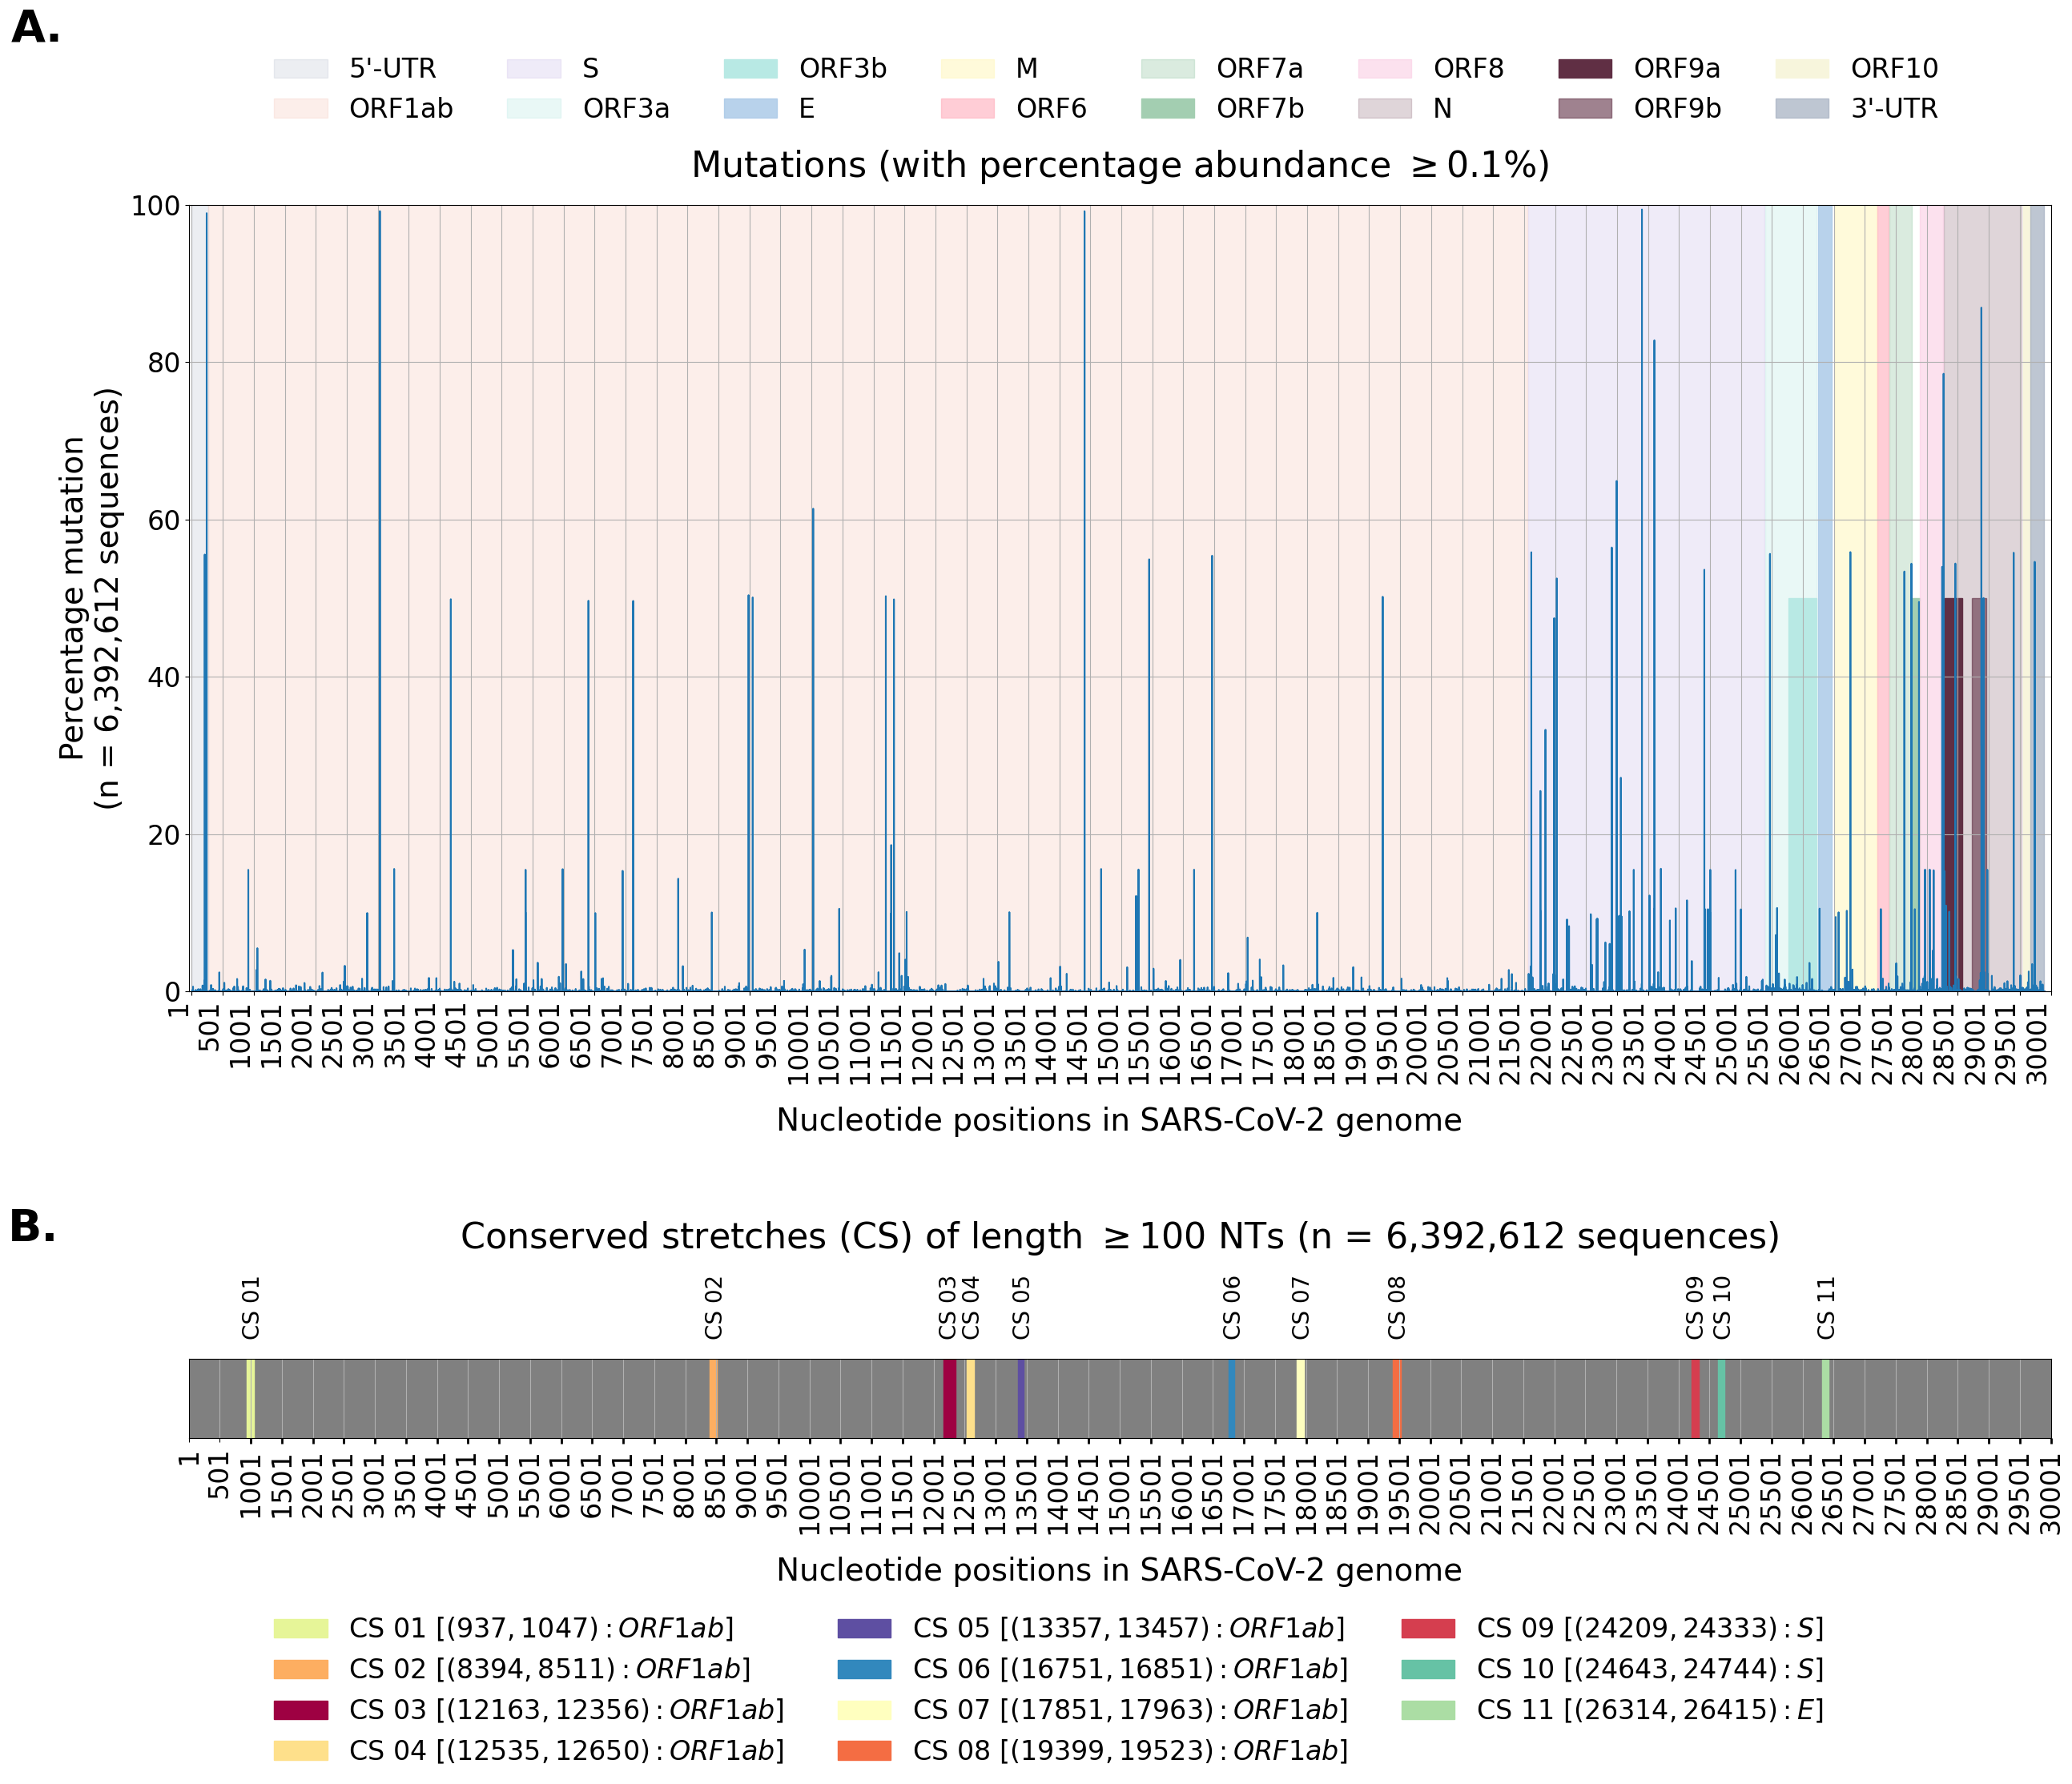

In [25]:
plt.style.use("default")
plt.rcParams["figure.figsize"] = (30, 20)
plt.rcParams["axes.facecolor"] = (1, 1, 1)
plt.rcParams["savefig.facecolor"] = (1, 1, 1)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, gridspec_kw={"height_ratios": [10, 1]})

# --------------------------------------------------------

ax1.grid(True)
ax1.set_title(r"Mutations (with percentage abundance $\geq$0.1%)", fontsize=32, pad=25)
ax1.set_ylabel(f"Percentage mutation\n(n = {nseqs:,} sequences)", fontsize=28)
ax1.set_xlabel("Nucleotide positions in SARS-CoV-2 genome", fontsize=28, labelpad=20)

ax1.plot(df_viz_per_pt1.genome_positions, df_viz_per_pt1.per_mutated)

ax1.set_xticks(
    np.arange(
        min(df_viz_per_pt1.genome_positions),
        max(df_viz_per_pt1.genome_positions) + 501,
        500,
    ),
    rotation=90,
    fontsize=24,
)
ax1.set_xlim(-50, 30001)
ax1.set_ylim(0, 100)
plt.setp(ax1.get_xticklabels(), rotation=90, ha="right", fontsize=24)
plt.setp(ax1.get_yticklabels(), rotation=0, ha="right", fontsize=24)

add_sars_cov2_patches_to_plot(
    ax1,
    legend_location=(0.04, 1.09),
    legend_font_size=24,
    ymax=100,
    legend_visibility=True,
    frameon_flag=False,
    ncol_val=8,
)

# ---------------------------------------------------------------------

plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.major.width"] = 2
plt.rcParams["xtick.bottom"] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["xtick.labelsize"] = 24

color_pointer = 0
my_cmap = cm.get_cmap("Spectral", len(consecutive_stretches_list_geq100))
# for  ListedColormap
# print(my_cmap.colors)
# for  LinearSegmentedColormap
# print(my_cmap(range(len(consecutive_stretches_list_geq100))))
patches_list = list()
ax2.set_xlim(1, 29904)
ax2.set_ylim(0, 1)

d1 = dict()
c = 1
helper_dict = dict()

for x in sorted(consecutive_stretches_list_geq100, key=lambda x: x[1]):
    gene_set = set()
    for key in sars_cov_2_genome:
        # Checking the start, middle and 
        # end positions of the stretch for gene annotations
        if x[1] in range(key[0], key[1] + 1):
            gene_set.add(sars_cov_2_genome[key])
        if int(np.median([x[1], x[2]])) in range(key[0], key[1] + 1):
            gene_set.add(sars_cov_2_genome[key])
        if x[2] in range(key[0], key[1] + 1):
            gene_set.add(sars_cov_2_genome[key])
    annotation_str = ", ".join([g for g in gene_set])
    d1[x[1]] = f"CS {c:02} $[({x[1]}, {x[2]}): {annotation_str}]$"
    c += 1

c = 0

for x in consecutive_stretches_list_geq100:
    patches_list.append(
        mpatches.Rectangle(
            (x[1], 0),
            x[0],
            100,
            fill=True,
            alpha=1,
            linewidth=1,
            label=d1[x[1]],
            color=my_cmap(range(len(consecutive_stretches_list_geq100)))[c]
        )
    )
    helper_dict[int(d1[x[1]][3:5])] = patches_list[-1]
    ax2.add_patch(patches_list[-1])
    ax2.text(
        x[1] + 100,
        1.25,
        rf"{d1[x[1]][:5]}",
        ha="center",
        va="bottom",
        rotation=90,
        color="black",
        size=20,
    )
    c += 1

ax2.set_title(
    "Conserved stretches (CS) of length "
    r"$\geq$100 NTs "
    f"(n = {nseqs:,} sequences)",
    size=32,
    pad=100,
)
ax2.set_xlabel("Nucleotide positions in SARS-CoV-2 genome", fontsize=28, labelpad=20)
ax2.set_xticks(np.arange(1, 29903 + 100, step=500), fontsize=24, rotation=90)
ax2.set_yticks([])
ax2.set_facecolor("grey")  ## f3f3f3
ax2.tick_params(axis="x", which="major", pad=5)

ax1.text(
    0 - 2500,
    120.75,
    r"A.",
    ha="center",
    va="baseline",
    rotation=0,
    color="black",
    size=40,
    fontweight="bold",
)
ax2.text(
    0 - 2500,
    2.5,
    r"B.",
    ha="center",
    va="baseline",
    rotation=0,
    color="black",
    size=40,
    fontweight="bold",
)

ax2.legend(
    handles=[v for k, v in sorted(helper_dict.items(), key=lambda item: item[0])],
    loc=(0.04, -4.3),
    fontsize=24,
    frameon=False,
    mode=None,
    ncol=3,
    labelspacing=0.5,
    edgecolor="black",
)
plt.xticks(rotation=90, fontsize=24)
ax2.yaxis.grid(False)
ax2.xaxis.grid(True)
# ---------------------------------------------------------------
plt.subplots_adjust(wspace=0, hspace=0.85)

# plt.savefig('../plots/fig_01.png', dpi=1000, bbox_inches='tight')

### Zoomed-in picture of S-gene for Fig. 1. A

(0.0, 100.0)

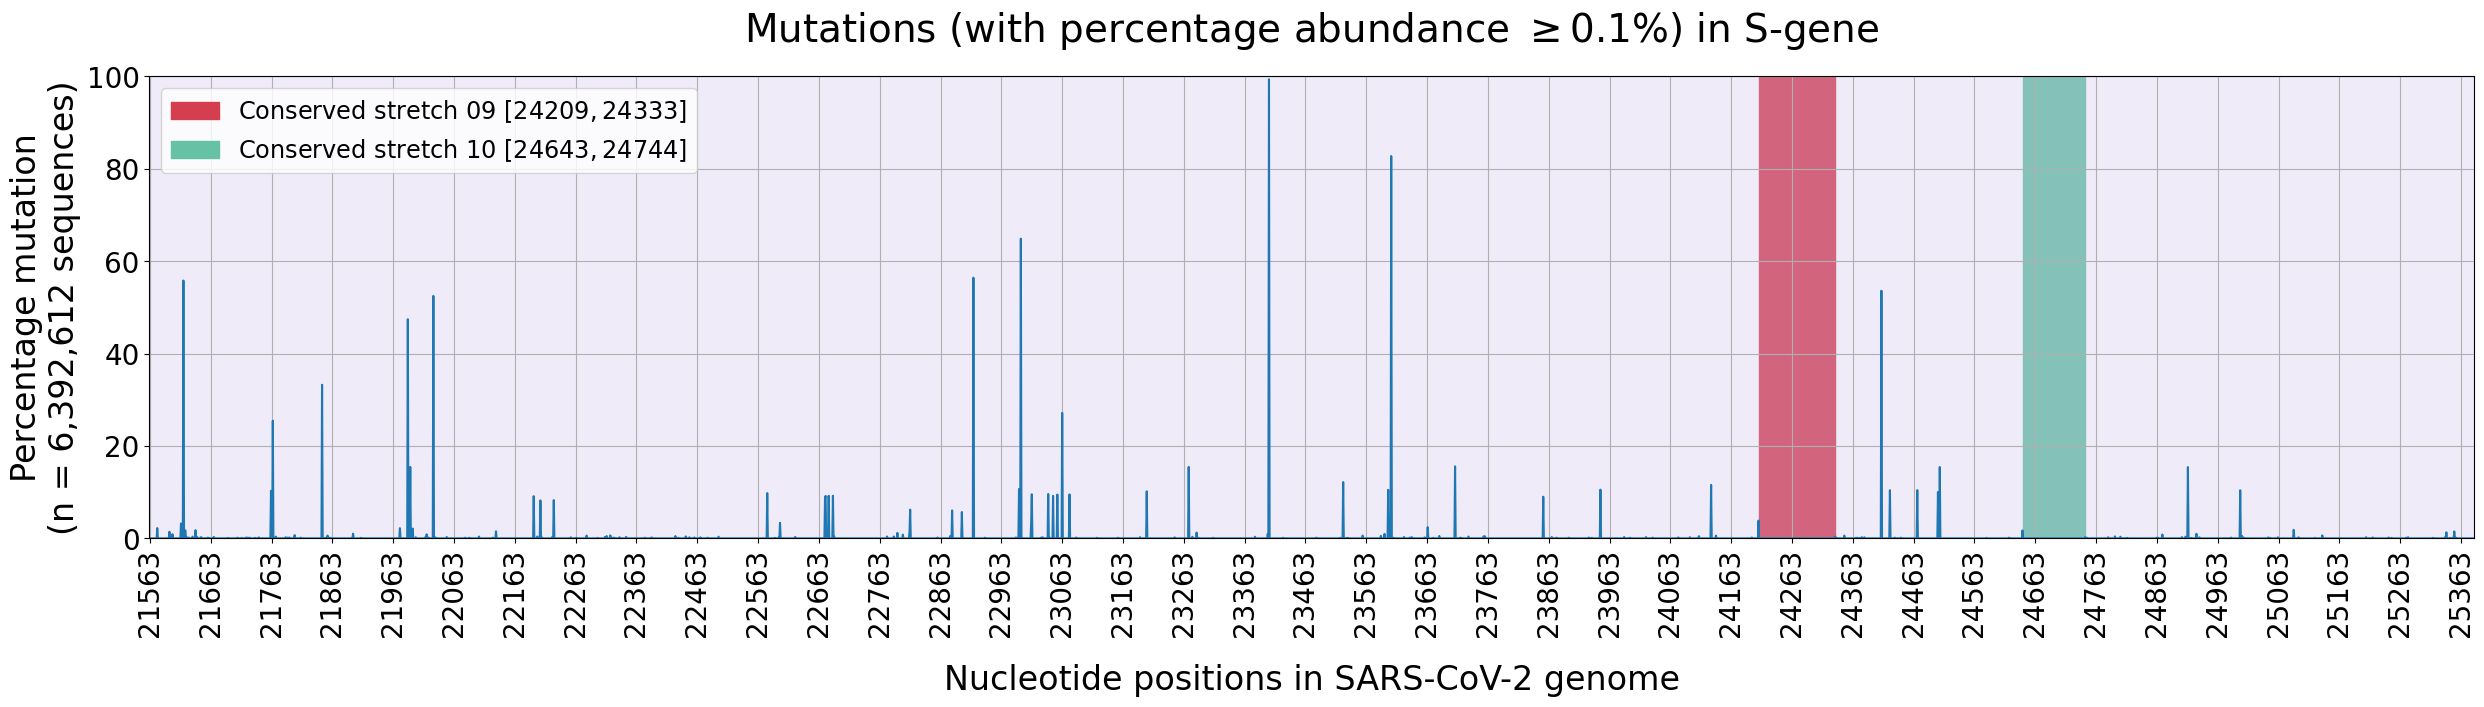

In [26]:
plt.style.use("default")

plt.figure(figsize=(30, 6), facecolor=(1, 1, 1))
plt.grid(True)

plt.title(
    r"Mutations (with percentage abundance $\geq$0.1%) in S-gene", fontsize=28, pad=25
)
plt.ylabel(f"Percentage mutation\n(n = {nseqs:,} sequences)", fontsize=24)
plt.xlabel("Nucleotide positions in SARS-CoV-2 genome", fontsize=24, labelpad=20)

plt.plot(df_gene_S.genome_positions, df_gene_S.per_mutated)

# Patches for putative conserved regions
plt.gca().add_patch(
    mpatches.Rectangle(
        (24209, 0),
        125,
        100,
        fill=True,
        alpha=1,
        linewidth=1,
        label=f"Conserved stretch 09 $[24209, 24333]$",
        color=my_cmap(range(11))[2 - 1],
    )
)
plt.gca().add_patch(
    mpatches.Rectangle(
        (24643, 0),
        102,
        100,
        fill=True,
        alpha=1,
        linewidth=1,
        label=f"Conserved stretch 10 $[24643, 24744]$",
        color=my_cmap(range(11))[9 - 1],
    )
)

max_val = 100
rect_S = mpatches.Rectangle(
    (21563, 0), 3821, max_val, fill=True, color="#CCBFE9", alpha=0.3, linewidth=1
)
plt.gca().add_patch(rect_S)


plt.xticks(
    np.arange(
        min(df_gene_S.genome_positions), max(df_gene_S.genome_positions) + 1, 100
    ),
    rotation=90,
    fontsize=20,
)
plt.yticks(fontsize=20)

plt.legend(loc="best", fontsize="xx-large")
# plt.legend(loc="best", fontsize="xx-large", facecolor='#f3f3f3')

plt.xlim(21562, 25384 + 1)
plt.ylim(0, 100)

# plt.savefig('./plots_region_conservation/panel_01_C.png', dpi=1000, bbox_inches='tight')

### Zoomed-in picture of N-gene for Fig. 1. A

(0.0, 100.0)

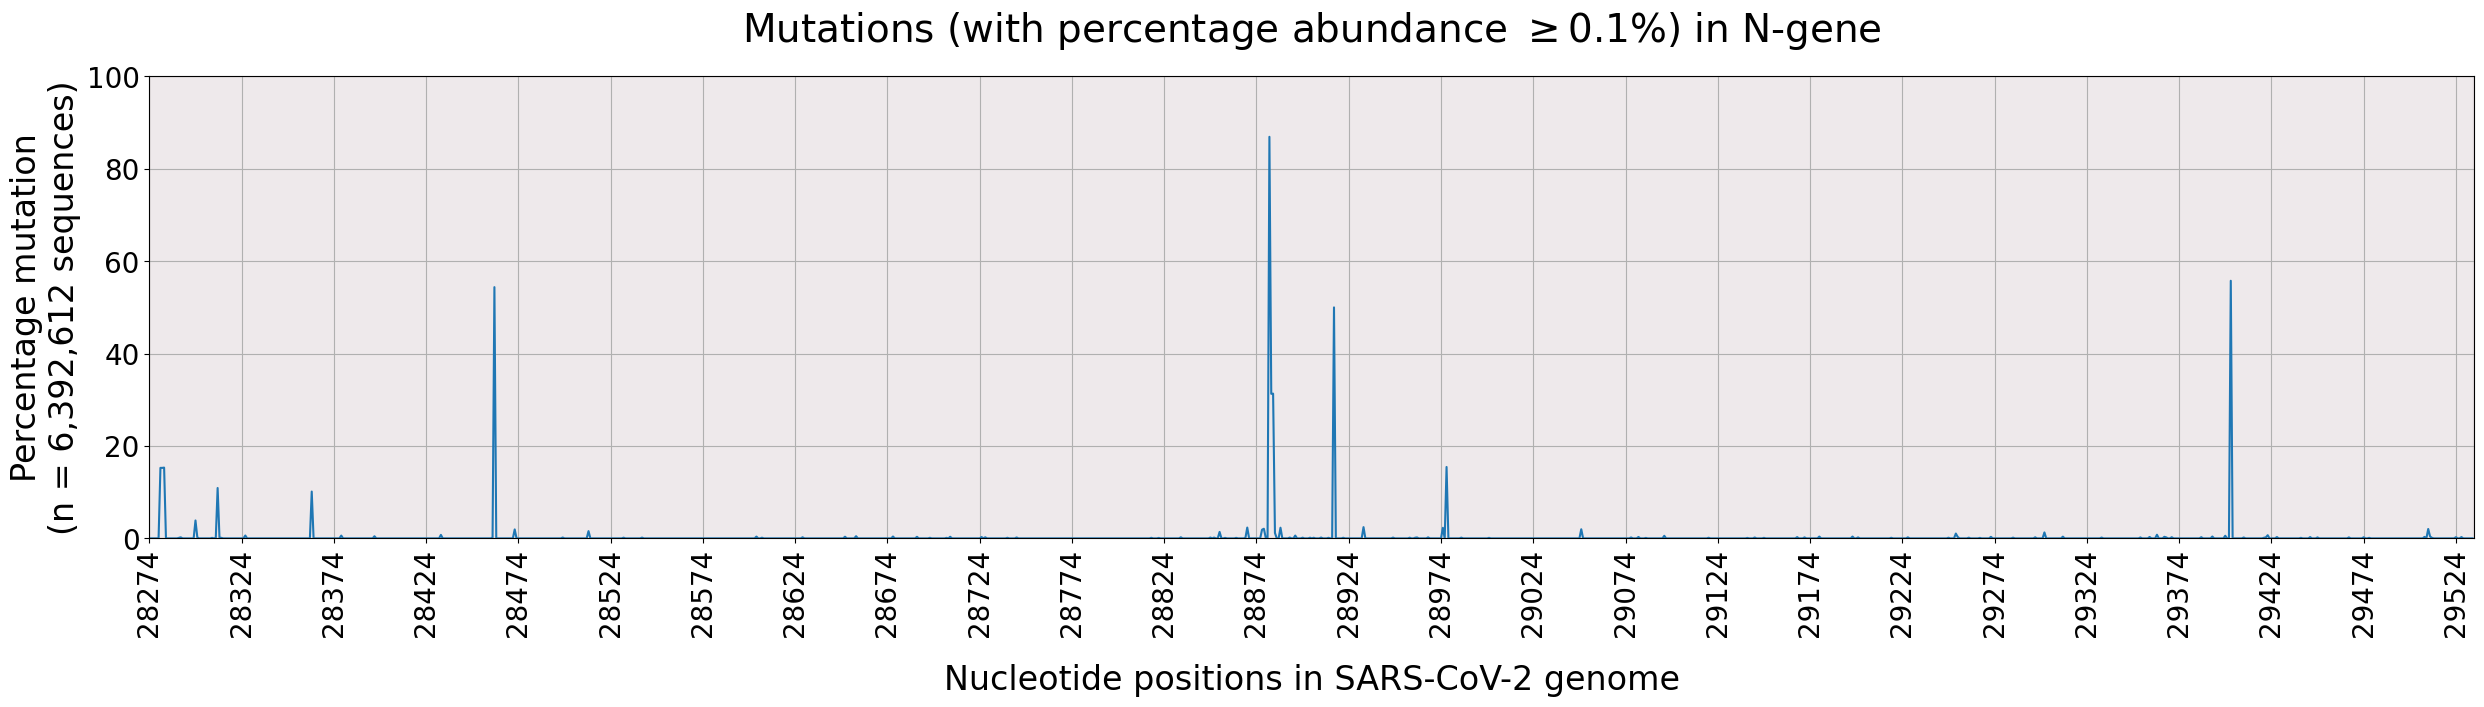

In [27]:
plt.style.use("default")

plt.figure(figsize=(30, 6), facecolor=(1, 1, 1))
plt.grid(True)

plt.title(
    r"Mutations (with percentage abundance $\geq$0.1%) in N-gene", fontsize=28, pad=25
)
plt.ylabel(f"Percentage mutation\n(n = {nseqs:,} sequences)", fontsize=24)
plt.xlabel("Nucleotide positions in SARS-CoV-2 genome", fontsize=24, labelpad=20)

plt.plot(df_gene_N.genome_positions, df_gene_N.per_mutated)

max_val = 100
rect_N = mpatches.Rectangle(
    (28274, 0),
    1259,
    max_val,
    fill=True,
    color="#602F44",
    alpha=0.1,
    linewidth=1,
    label="N",
)
plt.gca().add_patch(rect_N)

plt.xticks(
    np.arange(min(df_gene_N.genome_positions), max(df_gene_N.genome_positions) + 1, 50),
    rotation=90,
    fontsize=20,
)
plt.yticks(fontsize=20)

plt.xlim(28274, 29533 + 1)
plt.ylim(0, 100)

# plt.savefig('./plots_region_conservation/panel_01_D.png', dpi=1000, bbox_inches='tight')

# Saving the files

## Saving Supplementary Table 7

In [28]:
table_01 = df_primers.copy()
table_01 = table_01.assign(
    mutations_in_this_region="", num_of_mutations_in_this_region=0
)

for row in table_01.itertuples():
    mutations_present = list(
        df_per_pt1[
            (df_per_pt1.pos >= row.start_pos) & (df_per_pt1.pos <= row.end_pos)
        ].mutation_name
    )
    table_01.at[row.Index, "mutations_in_this_region"] = ", ".join(mutations_present)
    table_01.at[row.Index, "num_of_mutations_in_this_region"] = len(mutations_present)


table_01 = table_01.assign(new_col=0)

for row in table_01.itertuples():
    mutations_list = row.mutations_in_this_region.replace(r" ", "").split(",")
    temp = []
    for mutation in mutations_list:
        temp_per_abundance = list(
            df_per_pt1[df_per_pt1.mutation_name == mutation].per_abundance
        )
        if temp_per_abundance:
            per = temp_per_abundance[0]
            temp.append(f"{mutation}({per:.2f}%)")
        else:
            temp.append(f"{np.NaN}")
    table_01.at[row.Index, "new_col"] = ", ".join(temp)

table_01.rename(
    columns={
        "new_col": "Mutations with percentage abundance >= 0.1 in this region",
        "num_of_mutations_in_this_region": "Total number of Mutations with percentage abundance >= 0.1 in this region",
    },
    inplace=True,
)

del table_01["mutations_in_this_region"]
del table_01["start_pos"]
del table_01["end_pos"]

# # No need to save this table now as we'll save a 
# # modified version of this table with color formatting below
# table_01.to_excel(
#     '../Supplementary_files/Table_01.xlsx',
#     index=False,
#     sheet_name='primers,probes RTPCR SARS-CoV-2',
#     header=True
# )

table_01.head()

,Source,Primer/Probe Name,Target Gene,Sequence,Length,Genomic Region,Total number of Mutations with percentage abundance >= 0.1 in this region,Mutations with percentage abundance >= 0.1 in this region
0,"China CDC, China",Forward (F),ORF1ab,CCCTGTGGGTTTTACACTTAA,21,"13,342–13,362",1,C13356T(0.11%)
1,"China CDC, China",Reverse (R),ORF1ab,ACGATTGTGCATCAGCTGA,19,"13,442–13,460",1,C13458T(0.20%)
2,"China CDC, China",Fluorescence probe (P),ORF1ab,CCGTCTGCGGTATGTGGAAAGGTTATGG,28,"13,377–13,404",0,nan
3,"China CDC, China",Forward (F),N,GGGGAACTTCTCCTGCTAGAAT,22,"28,881–28,902",9,"G28881T(55.52%), G28881A(31.40%), G28883C(31.3..."
4,"China CDC, China",Reverse (R),N,CAGACATTTTGCTCTCAAGCTG,22,"28,958–28,979",7,"C28977T(15.45%), G28975T(1.07%), G28975A(0.64%..."


In [29]:
# Genbank ID: MN908947.3
ref_seq = "ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTCGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGATTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTACACGGAACGTTCTGAAAAGAGCTATGAATTGCAGACACCTTTTGAAATTAAATTGGCAAAGAAATTTGACACCTTCAATGGGGAATGTCCAAATTTTGTATTTCCCTTAAATTCCATAATCAAGACTATTCAACCAAGGGTTGAAAAGAAAAAGCTTGATGGCTTTATGGGTAGAATTCGATCTGTCTATCCAGTTGCGTCACCAAATGAATGCAACCAAATGTGCCTTTCAACTCTCATGAAGTGTGATCATTGTGGTGAAACTTCATGGCAGACGGGCGATTTTGTTAAAGCCACTTGCGAATTTTGTGGCACTGAGAATTTGACTAAAGAAGGTGCCACTACTTGTGGTTACTTACCCCAAAATGCTGTTGTTAAAATTTATTGTCCAGCATGTCACAATTCAGAAGTAGGACCTGAGCATAGTCTTGCCGAATACCATAATGAATCTGGCTTGAAAACCATTCTTCGTAAGGGTGGTCGCACTATTGCCTTTGGAGGCTGTGTGTTCTCTTATGTTGGTTGCCATAACAAGTGTGCCTATTGGGTTCCACGTGCTAGCGCTAACATAGGTTGTAACCATACAGGTGTTGTTGGAGAAGGTTCCGAAGGTCTTAATGACAACCTTCTTGAAATACTCCAAAAAGAGAAAGTCAACATCAATATTGTTGGTGACTTTAAACTTAATGAAGAGATCGCCATTATTTTGGCATCTTTTTCTGCTTCCACAAGTGCTTTTGTGGAAACTGTGAAAGGTTTGGATTATAAAGCATTCAAACAAATTGTTGAATCCTGTGGTAATTTTAAAGTTACAAAAGGAAAAGCTAAAAAAGGTGCCTGGAATATTGGTGAACAGAAATCAATACTGAGTCCTCTTTATGCATTTGCATCAGAGGCTGCTCGTGTTGTACGATCAATTTTCTCCCGCACTCTTGAAACTGCTCAAAATTCTGTGCGTGTTTTACAGAAGGCCGCTATAACAATACTAGATGGAATTTCACAGTATTCACTGAGACTCATTGATGCTATGATGTTCACATCTGATTTGGCTACTAACAATCTAGTTGTAATGGCCTACATTACAGGTGGTGTTGTTCAGTTGACTTCGCAGTGGCTAACTAACATCTTTGGCACTGTTTATGAAAAACTCAAACCCGTCCTTGATTGGCTTGAAGAGAAGTTTAAGGAAGGTGTAGAGTTTCTTAGAGACGGTTGGGAAATTGTTAAATTTATCTCAACCTGTGCTTGTGAAATTGTCGGTGGACAAATTGTCACCTGTGCAAAGGAAATTAAGGAGAGTGTTCAGACATTCTTTAAGCTTGTAAATAAATTTTTGGCTTTGTGTGCTGACTCTATCATTATTGGTGGAGCTAAACTTAAAGCCTTGAATTTAGGTGAAACATTTGTCACGCACTCAAAGGGATTGTACAGAAAGTGTGTTAAATCCAGAGAAGAAACTGGCCTACTCATGCCTCTAAAAGCCCCAAAAGAAATTATCTTCTTAGAGGGAGAAACACTTCCCACAGAAGTGTTAACAGAGGAAGTTGTCTTGAAAACTGGTGATTTACAACCATTAGAACAACCTACTAGTGAAGCTGTTGAAGCTCCATTGGTTGGTACACCAGTTTGTATTAACGGGCTTATGTTGCTCGAAATCAAAGACACAGAAAAGTACTGTGCCCTTGCACCTAATATGATGGTAACAAACAATACCTTCACACTCAAAGGCGGTGCACCAACAAAGGTTACTTTTGGTGATGACACTGTGATAGAAGTGCAAGGTTACAAGAGTGTGAATATCACTTTTGAACTTGATGAAAGGATTGATAAAGTACTTAATGAGAAGTGCTCTGCCTATACAGTTGAACTCGGTACAGAAGTAAATGAGTTCGCCTGTGTTGTGGCAGATGCTGTCATAAAAACTTTGCAACCAGTATCTGAATTACTTACACCACTGGGCATTGATTTAGATGAGTGGAGTATGGCTACATACTACTTATTTGATGAGTCTGGTGAGTTTAAATTGGCTTCACATATGTATTGTTCTTTCTACCCTCCAGATGAGGATGAAGAAGAAGGTGATTGTGAAGAAGAAGAGTTTGAGCCATCAACTCAATATGAGTATGGTACTGAAGATGATTACCAAGGTAAACCTTTGGAATTTGGTGCCACTTCTGCTGCTCTTCAACCTGAAGAAGAGCAAGAAGAAGATTGGTTAGATGATGATAGTCAACAAACTGTTGGTCAACAAGACGGCAGTGAGGACAATCAGACAACTACTATTCAAACAATTGTTGAGGTTCAACCTCAATTAGAGATGGAACTTACACCAGTTGTTCAGACTATTGAAGTGAATAGTTTTAGTGGTTATTTAAAACTTACTGACAATGTATACATTAAAAATGCAGACATTGTGGAAGAAGCTAAAAAGGTAAAACCAACAGTGGTTGTTAATGCAGCCAATGTTTACCTTAAACATGGAGGAGGTGTTGCAGGAGCCTTAAATAAGGCTACTAACAATGCCATGCAAGTTGAATCTGATGATTACATAGCTACTAATGGACCACTTAAAGTGGGTGGTAGTTGTGTTTTAAGCGGACACAATCTTGCTAAACACTGTCTTCATGTTGTCGGCCCAAATGTTAACAAAGGTGAAGACATTCAACTTCTTAAGAGTGCTTATGAAAATTTTAATCAGCACGAAGTTCTACTTGCACCATTATTATCAGCTGGTATTTTTGGTGCTGACCCTATACATTCTTTAAGAGTTTGTGTAGATACTGTTCGCACAAATGTCTACTTAGCTGTCTTTGATAAAAATCTCTATGACAAACTTGTTTCAAGCTTTTTGGAAATGAAGAGTGAAAAGCAAGTTGAACAAAAGATCGCTGAGATTCCTAAAGAGGAAGTTAAGCCATTTATAACTGAAAGTAAACCTTCAGTTGAACAGAGAAAACAAGATGATAAGAAAATCAAAGCTTGTGTTGAAGAAGTTACAACAACTCTGGAAGAAACTAAGTTCCTCACAGAAAACTTGTTACTTTATATTGACATTAATGGCAATCTTCATCCAGATTCTGCCACTCTTGTTAGTGACATTGACATCACTTTCTTAAAGAAAGATGCTCCATATATAGTGGGTGATGTTGTTCAAGAGGGTGTTTTAACTGCTGTGGTTATACCTACTAAAAAGGCTGGTGGCACTACTGAAATGCTAGCGAAAGCTTTGAGAAAAGTGCCAACAGACAATTATATAACCACTTACCCGGGTCAGGGTTTAAATGGTTACACTGTAGAGGAGGCAAAGACAGTGCTTAAAAAGTGTAAAAGTGCCTTTTACATTCTACCATCTATTATCTCTAATGAGAAGCAAGAAATTCTTGGAACTGTTTCTTGGAATTTGCGAGAAATGCTTGCACATGCAGAAGAAACACGCAAATTAATGCCTGTCTGTGTGGAAACTAAAGCCATAGTTTCAACTATACAGCGTAAATATAAGGGTATTAAAATACAAGAGGGTGTGGTTGATTATGGTGCTAGATTTTACTTTTACACCAGTAAAACAACTGTAGCGTCACTTATCAACACACTTAACGATCTAAATGAAACTCTTGTTACAATGCCACTTGGCTATGTAACACATGGCTTAAATTTGGAAGAAGCTGCTCGGTATATGAGATCTCTCAAAGTGCCAGCTACAGTTTCTGTTTCTTCACCTGATGCTGTTACAGCGTATAATGGTTATCTTACTTCTTCTTCTAAAACACCTGAAGAACATTTTATTGAAACCATCTCACTTGCTGGTTCCTATAAAGATTGGTCCTATTCTGGACAATCTACACAACTAGGTATAGAATTTCTTAAGAGAGGTGATAAAAGTGTATATTACACTAGTAATCCTACCACATTCCACCTAGATGGTGAAGTTATCACCTTTGACAATCTTAAGACACTTCTTTCTTTGAGAGAAGTGAGGACTATTAAGGTGTTTACAACAGTAGACAACATTAACCTCCACACGCAAGTTGTGGACATGTCAATGACATATGGACAACAGTTTGGTCCAACTTATTTGGATGGAGCTGATGTTACTAAAATAAAACCTCATAATTCACATGAAGGTAAAACATTTTATGTTTTACCTAATGATGACACTCTACGTGTTGAGGCTTTTGAGTACTACCACACAACTGATCCTAGTTTTCTGGGTAGGTACATGTCAGCATTAAATCACACTAAAAAGTGGAAATACCCACAAGTTAATGGTTTAACTTCTATTAAATGGGCAGATAACAACTGTTATCTTGCCACTGCATTGTTAACACTCCAACAAATAGAGTTGAAGTTTAATCCACCTGCTCTACAAGATGCTTATTACAGAGCAAGGGCTGGTGAAGCTGCTAACTTTTGTGCACTTATCTTAGCCTACTGTAATAAGACAGTAGGTGAGTTAGGTGATGTTAGAGAAACAATGAGTTACTTGTTTCAACATGCCAATTTAGATTCTTGCAAAAGAGTCTTGAACGTGGTGTGTAAAACTTGTGGACAACAGCAGACAACCCTTAAGGGTGTAGAAGCTGTTATGTACATGGGCACACTTTCTTATGAACAATTTAAGAAAGGTGTTCAGATACCTTGTACGTGTGGTAAACAAGCTACAAAATATCTAGTACAACAGGAGTCACCTTTTGTTATGATGTCAGCACCACCTGCTCAGTATGAACTTAAGCATGGTACATTTACTTGTGCTAGTGAGTACACTGGTAATTACCAGTGTGGTCACTATAAACATATAACTTCTAAAGAAACTTTGTATTGCATAGACGGTGCTTTACTTACAAAGTCCTCAGAATACAAAGGTCCTATTACGGATGTTTTCTACAAAGAAAACAGTTACACAACAACCATAAAACCAGTTACTTATAAATTGGATGGTGTTGTTTGTACAGAAATTGACCCTAAGTTGGACAATTATTATAAGAAAGACAATTCTTATTTCACAGAGCAACCAATTGATCTTGTACCAAACCAACCATATCCAAACGCAAGCTTCGATAATTTTAAGTTTGTATGTGATAATATCAAATTTGCTGATGATTTAAACCAGTTAACTGGTTATAAGAAACCTGCTTCAAGAGAGCTTAAAGTTACATTTTTCCCTGACTTAAATGGTGATGTGGTGGCTATTGATTATAAACACTACACACCCTCTTTTAAGAAAGGAGCTAAATTGTTACATAAACCTATTGTTTGGCATGTTAACAATGCAACTAATAAAGCCACGTATAAACCAAATACCTGGTGTATACGTTGTCTTTGGAGCACAAAACCAGTTGAAACATCAAATTCGTTTGATGTACTGAAGTCAGAGGACGCGCAGGGAATGGATAATCTTGCCTGCGAAGATCTAAAACCAGTCTCTGAAGAAGTAGTGGAAAATCCTACCATACAGAAAGACGTTCTTGAGTGTAATGTGAAAACTACCGAAGTTGTAGGAGACATTATACTTAAACCAGCAAATAATAGTTTAAAAATTACAGAAGAGGTTGGCCACACAGATCTAATGGCTGCTTATGTAGACAATTCTAGTCTTACTATTAAGAAACCTAATGAATTATCTAGAGTATTAGGTTTGAAAACCCTTGCTACTCATGGTTTAGCTGCTGTTAATAGTGTCCCTTGGGATACTATAGCTAATTATGCTAAGCCTTTTCTTAACAAAGTTGTTAGTACAACTACTAACATAGTTACACGGTGTTTAAACCGTGTTTGTACTAATTATATGCCTTATTTCTTTACTTTATTGCTACAATTGTGTACTTTTACTAGAAGTACAAATTCTAGAATTAAAGCATCTATGCCGACTACTATAGCAAAGAATACTGTTAAGAGTGTCGGTAAATTTTGTCTAGAGGCTTCATTTAATTATTTGAAGTCACCTAATTTTTCTAAACTGATAAATATTATAATTTGGTTTTTACTATTAAGTGTTTGCCTAGGTTCTTTAATCTACTCAACCGCTGCTTTAGGTGTTTTAATGTCTAATTTAGGCATGCCTTCTTACTGTACTGGTTACAGAGAAGGCTATTTGAACTCTACTAATGTCACTATTGCAACCTACTGTACTGGTTCTATACCTTGTAGTGTTTGTCTTAGTGGTTTAGATTCTTTAGACACCTATCCTTCTTTAGAAACTATACAAATTACCATTTCATCTTTTAAATGGGATTTAACTGCTTTTGGCTTAGTTGCAGAGTGGTTTTTGGCATATATTCTTTTCACTAGGTTTTTCTATGTACTTGGATTGGCTGCAATCATGCAATTGTTTTTCAGCTATTTTGCAGTACATTTTATTAGTAATTCTTGGCTTATGTGGTTAATAATTAATCTTGTACAAATGGCCCCGATTTCAGCTATGGTTAGAATGTACATCTTCTTTGCATCATTTTATTATGTATGGAAAAGTTATGTGCATGTTGTAGACGGTTGTAATTCATCAACTTGTATGATGTGTTACAAACGTAATAGAGCAACAAGAGTCGAATGTACAACTATTGTTAATGGTGTTAGAAGGTCCTTTTATGTCTATGCTAATGGAGGTAAAGGCTTTTGCAAACTACACAATTGGAATTGTGTTAATTGTGATACATTCTGTGCTGGTAGTACATTTATTAGTGATGAAGTTGCGAGAGACTTGTCACTACAGTTTAAAAGACCAATAAATCCTACTGACCAGTCTTCTTACATCGTTGATAGTGTTACAGTGAAGAATGGTTCCATCCATCTTTACTTTGATAAAGCTGGTCAAAAGACTTATGAAAGACATTCTCTCTCTCATTTTGTTAACTTAGACAACCTGAGAGCTAATAACACTAAAGGTTCATTGCCTATTAATGTTATAGTTTTTGATGGTAAATCAAAATGTGAAGAATCATCTGCAAAATCAGCGTCTGTTTACTACAGTCAGCTTATGTGTCAACCTATACTGTTACTAGATCAGGCATTAGTGTCTGATGTTGGTGATAGTGCGGAAGTTGCAGTTAAAATGTTTGATGCTTACGTTAATACGTTTTCATCAACTTTTAACGTACCAATGGAAAAACTCAAAACACTAGTTGCAACTGCAGAAGCTGAACTTGCAAAGAATGTGTCCTTAGACAATGTCTTATCTACTTTTATTTCAGCAGCTCGGCAAGGGTTTGTTGATTCAGATGTAGAAACTAAAGATGTTGTTGAATGTCTTAAATTGTCACATCAATCTGACATAGAAGTTACTGGCGATAGTTGTAATAACTATATGCTCACCTATAACAAAGTTGAAAACATGACACCCCGTGACCTTGGTGCTTGTATTGACTGTAGTGCGCGTCATATTAATGCGCAGGTAGCAAAAAGTCACAACATTGCTTTGATATGGAACGTTAAAGATTTCATGTCATTGTCTGAACAACTACGAAAACAAATACGTAGTGCTGCTAAAAAGAATAACTTACCTTTTAAGTTGACATGTGCAACTACTAGACAAGTTGTTAATGTTGTAACAACAAAGATAGCACTTAAGGGTGGTAAAATTGTTAATAATTGGTTGAAGCAGTTAATTAAAGTTACACTTGTGTTCCTTTTTGTTGCTGCTATTTTCTATTTAATAACACCTGTTCATGTCATGTCTAAACATACTGACTTTTCAAGTGAAATCATAGGATACAAGGCTATTGATGGTGGTGTCACTCGTGACATAGCATCTACAGATACTTGTTTTGCTAACAAACATGCTGATTTTGACACATGGTTTAGCCAGCGTGGTGGTAGTTATACTAATGACAAAGCTTGCCCATTGATTGCTGCAGTCATAACAAGAGAAGTGGGTTTTGTCGTGCCTGGTTTGCCTGGCACGATATTACGCACAACTAATGGTGACTTTTTGCATTTCTTACCTAGAGTTTTTAGTGCAGTTGGTAACATCTGTTACACACCATCAAAACTTATAGAGTACACTGACTTTGCAACATCAGCTTGTGTTTTGGCTGCTGAATGTACAATTTTTAAAGATGCTTCTGGTAAGCCAGTACCATATTGTTATGATACCAATGTACTAGAAGGTTCTGTTGCTTATGAAAGTTTACGCCCTGACACACGTTATGTGCTCATGGATGGCTCTATTATTCAATTTCCTAACACCTACCTTGAAGGTTCTGTTAGAGTGGTAACAACTTTTGATTCTGAGTACTGTAGGCACGGCACTTGTGAAAGATCAGAAGCTGGTGTTTGTGTATCTACTAGTGGTAGATGGGTACTTAACAATGATTATTACAGATCTTTACCAGGAGTTTTCTGTGGTGTAGATGCTGTAAATTTACTTACTAATATGTTTACACCACTAATTCAACCTATTGGTGCTTTGGACATATCAGCATCTATAGTAGCTGGTGGTATTGTAGCTATCGTAGTAACATGCCTTGCCTACTATTTTATGAGGTTTAGAAGAGCTTTTGGTGAATACAGTCATGTAGTTGCCTTTAATACTTTACTATTCCTTATGTCATTCACTGTACTCTGTTTAACACCAGTTTACTCATTCTTACCTGGTGTTTATTCTGTTATTTACTTGTACTTGACATTTTATCTTACTAATGATGTTTCTTTTTTAGCACATATTCAGTGGATGGTTATGTTCACACCTTTAGTACCTTTCTGGATAACAATTGCTTATATCATTTGTATTTCCACAAAGCATTTCTATTGGTTCTTTAGTAATTACCTAAAGAGACGTGTAGTCTTTAATGGTGTTTCCTTTAGTACTTTTGAAGAAGCTGCGCTGTGCACCTTTTTGTTAAATAAAGAAATGTATCTAAAGTTGCGTAGTGATGTGCTATTACCTCTTACGCAATATAATAGATACTTAGCTCTTTATAATAAGTACAAGTATTTTAGTGGAGCAATGGATACAACTAGCTACAGAGAAGCTGCTTGTTGTCATCTCGCAAAGGCTCTCAATGACTTCAGTAACTCAGGTTCTGATGTTCTTTACCAACCACCACAAACCTCTATCACCTCAGCTGTTTTGCAGAGTGGTTTTAGAAAAATGGCATTCCCATCTGGTAAAGTTGAGGGTTGTATGGTACAAGTAACTTGTGGTACAACTACACTTAACGGTCTTTGGCTTGATGACGTAGTTTACTGTCCAAGACATGTGATCTGCACCTCTGAAGACATGCTTAACCCTAATTATGAAGATTTACTCATTCGTAAGTCTAATCATAATTTCTTGGTACAGGCTGGTAATGTTCAACTCAGGGTTATTGGACATTCTATGCAAAATTGTGTACTTAAGCTTAAGGTTGATACAGCCAATCCTAAGACACCTAAGTATAAGTTTGTTCGCATTCAACCAGGACAGACTTTTTCAGTGTTAGCTTGTTACAATGGTTCACCATCTGGTGTTTACCAATGTGCTATGAGGCCCAATTTCACTATTAAGGGTTCATTCCTTAATGGTTCATGTGGTAGTGTTGGTTTTAACATAGATTATGACTGTGTCTCTTTTTGTTACATGCACCATATGGAATTACCAACTGGAGTTCATGCTGGCACAGACTTAGAAGGTAACTTTTATGGACCTTTTGTTGACAGGCAAACAGCACAAGCAGCTGGTACGGACACAACTATTACAGTTAATGTTTTAGCTTGGTTGTACGCTGCTGTTATAAATGGAGACAGGTGGTTTCTCAATCGATTTACCACAACTCTTAATGACTTTAACCTTGTGGCTATGAAGTACAATTATGAACCTCTAACACAAGACCATGTTGACATACTAGGACCTCTTTCTGCTCAAACTGGAATTGCCGTTTTAGATATGTGTGCTTCATTAAAAGAATTACTGCAAAATGGTATGAATGGACGTACCATATTGGGTAGTGCTTTATTAGAAGATGAATTTACACCTTTTGATGTTGTTAGACAATGCTCAGGTGTTACTTTCCAAAGTGCAGTGAAAAGAACAATCAAGGGTACACACCACTGGTTGTTACTCACAATTTTGACTTCACTTTTAGTTTTAGTCCAGAGTACTCAATGGTCTTTGTTCTTTTTTTTGTATGAAAATGCCTTTTTACCTTTTGCTATGGGTATTATTGCTATGTCTGCTTTTGCAATGATGTTTGTCAAACATAAGCATGCATTTCTCTGTTTGTTTTTGTTACCTTCTCTTGCCACTGTAGCTTATTTTAATATGGTCTATATGCCTGCTAGTTGGGTGATGCGTATTATGACATGGTTGGATATGGTTGATACTAGTTTGTCTGGTTTTAAGCTAAAAGACTGTGTTATGTATGCATCAGCTGTAGTGTTACTAATCCTTATGACAGCAAGAACTGTGTATGATGATGGTGCTAGGAGAGTGTGGACACTTATGAATGTCTTGACACTCGTTTATAAAGTTTATTATGGTAATGCTTTAGATCAAGCCATTTCCATGTGGGCTCTTATAATCTCTGTTACTTCTAACTACTCAGGTGTAGTTACAACTGTCATGTTTTTGGCCAGAGGTATTGTTTTTATGTGTGTTGAGTATTGCCCTATTTTCTTCATAACTGGTAATACACTTCAGTGTATAATGCTAGTTTATTGTTTCTTAGGCTATTTTTGTACTTGTTACTTTGGCCTCTTTTGTTTACTCAACCGCTACTTTAGACTGACTCTTGGTGTTTATGATTACTTAGTTTCTACACAGGAGTTTAGATATATGAATTCACAGGGACTACTCCCACCCAAGAATAGCATAGATGCCTTCAAACTCAACATTAAATTGTTGGGTGTTGGTGGCAAACCTTGTATCAAAGTAGCCACTGTACAGTCTAAAATGTCAGATGTAAAGTGCACATCAGTAGTCTTACTCTCAGTTTTGCAACAACTCAGAGTAGAATCATCATCTAAATTGTGGGCTCAATGTGTCCAGTTACACAATGACATTCTCTTAGCTAAAGATACTACTGAAGCCTTTGAAAAAATGGTTTCACTACTTTCTGTTTTGCTTTCCATGCAGGGTGCTGTAGACATAAACAAGCTTTGTGAAGAAATGCTGGACAACAGGGCAACCTTACAAGCTATAGCCTCAGAGTTTAGTTCCCTTCCATCATATGCAGCTTTTGCTACTGCTCAAGAAGCTTATGAGCAGGCTGTTGCTAATGGTGATTCTGAAGTTGTTCTTAAAAAGTTGAAGAAGTCTTTGAATGTGGCTAAATCTGAATTTGACCGTGATGCAGCCATGCAACGTAAGTTGGAAAAGATGGCTGATCAAGCTATGACCCAAATGTATAAACAGGCTAGATCTGAGGACAAGAGGGCAAAAGTTACTAGTGCTATGCAGACAATGCTTTTCACTATGCTTAGAAAGTTGGATAATGATGCACTCAACAACATTATCAACAATGCAAGAGATGGTTGTGTTCCCTTGAACATAATACCTCTTACAACAGCAGCCAAACTAATGGTTGTCATACCAGACTATAACACATATAAAAATACGTGTGATGGTACAACATTTACTTATGCATCAGCATTGTGGGAAATCCAACAGGTTGTAGATGCAGATAGTAAAATTGTTCAACTTAGTGAAATTAGTATGGACAATTCACCTAATTTAGCATGGCCTCTTATTGTAACAGCTTTAAGGGCCAATTCTGCTGTCAAATTACAGAATAATGAGCTTAGTCCTGTTGCACTACGACAGATGTCTTGTGCTGCCGGTACTACACAAACTGCTTGCACTGATGACAATGCGTTAGCTTACTACAACACAACAAAGGGAGGTAGGTTTGTACTTGCACTGTTATCCGATTTACAGGATTTGAAATGGGCTAGATTCCCTAAGAGTGATGGAACTGGTACTATCTATACAGAACTGGAACCACCTTGTAGGTTTGTTACAGACACACCTAAAGGTCCTAAAGTGAAGTATTTATACTTTATTAAAGGATTAAACAACCTAAATAGAGGTATGGTACTTGGTAGTTTAGCTGCCACAGTACGTCTACAAGCTGGTAATGCAACAGAAGTGCCTGCCAATTCAACTGTATTATCTTTCTGTGCTTTTGCTGTAGATGCTGCTAAAGCTTACAAAGATTATCTAGCTAGTGGGGGACAACCAATCACTAATTGTGTTAAGATGTTGTGTACACACACTGGTACTGGTCAGGCAATAACAGTTACACCGGAAGCCAATATGGATCAAGAATCCTTTGGTGGTGCATCGTGTTGTCTGTACTGCCGTTGCCACATAGATCATCCAAATCCTAAAGGATTTTGTGACTTAAAAGGTAAGTATGTACAAATACCTACAACTTGTGCTAATGACCCTGTGGGTTTTACACTTAAAAACACAGTCTGTACCGTCTGCGGTATGTGGAAAGGTTATGGCTGTAGTTGTGATCAACTCCGCGAACCCATGCTTCAGTCAGCTGATGCACAATCGTTTTTAAACGGGTTTGCGGTGTAAGTGCAGCCCGTCTTACACCGTGCGGCACAGGCACTAGTACTGATGTCGTATACAGGGCTTTTGACATCTACAATGATAAAGTAGCTGGTTTTGCTAAATTCCTAAAAACTAATTGTTGTCGCTTCCAAGAAAAGGACGAAGATGACAATTTAATTGATTCTTACTTTGTAGTTAAGAGACACACTTTCTCTAACTACCAACATGAAGAAACAATTTATAATTTACTTAAGGATTGTCCAGCTGTTGCTAAACATGACTTCTTTAAGTTTAGAATAGACGGTGACATGGTACCACATATATCACGTCAACGTCTTACTAAATACACAATGGCAGACCTCGTCTATGCTTTAAGGCATTTTGATGAAGGTAATTGTGACACATTAAAAGAAATACTTGTCACATACAATTGTTGTGATGATGATTATTTCAATAAAAAGGACTGGTATGATTTTGTAGAAAACCCAGATATATTACGCGTATACGCCAACTTAGGTGAACGTGTACGCCAAGCTTTGTTAAAAACAGTACAATTCTGTGATGCCATGCGAAATGCTGGTATTGTTGGTGTACTGACATTAGATAATCAAGATCTCAATGGTAACTGGTATGATTTCGGTGATTTCATACAAACCACGCCAGGTAGTGGAGTTCCTGTTGTAGATTCTTATTATTCATTGTTAATGCCTATATTAACCTTGACCAGGGCTTTAACTGCAGAGTCACATGTTGACACTGACTTAACAAAGCCTTACATTAAGTGGGATTTGTTAAAATATGACTTCACGGAAGAGAGGTTAAAACTCTTTGACCGTTATTTTAAATATTGGGATCAGACATACCACCCAAATTGTGTTAACTGTTTGGATGACAGATGCATTCTGCATTGTGCAAACTTTAATGTTTTATTCTCTACAGTGTTCCCACCTACAAGTTTTGGACCACTAGTGAGAAAAATATTTGTTGATGGTGTTCCATTTGTAGTTTCAACTGGATACCACTTCAGAGAGCTAGGTGTTGTACATAATCAGGATGTAAACTTACATAGCTCTAGACTTAGTTTTAAGGAATTACTTGTGTATGCTGCTGACCCTGCTATGCACGCTGCTTCTGGTAATCTATTACTAGATAAACGCACTACGTGCTTTTCAGTAGCTGCACTTACTAACAATGTTGCTTTTCAAACTGTCAAACCCGGTAATTTTAACAAAGACTTCTATGACTTTGCTGTGTCTAAGGGTTTCTTTAAGGAAGGAAGTTCTGTTGAATTAAAACACTTCTTCTTTGCTCAGGATGGTAATGCTGCTATCAGCGATTATGACTACTATCGTTATAATCTACCAACAATGTGTGATATCAGACAACTACTATTTGTAGTTGAAGTTGTTGATAAGTACTTTGATTGTTACGATGGTGGCTGTATTAATGCTAACCAAGTCATCGTCAACAACCTAGACAAATCAGCTGGTTTTCCATTTAATAAATGGGGTAAGGCTAGACTTTATTATGATTCAATGAGTTATGAGGATCAAGATGCACTTTTCGCATATACAAAACGTAATGTCATCCCTACTATAACTCAAATGAATCTTAAGTATGCCATTAGTGCAAAGAATAGAGCTCGCACCGTAGCTGGTGTCTCTATCTGTAGTACTATGACCAATAGACAGTTTCATCAAAAATTATTGAAATCAATAGCCGCCACTAGAGGAGCTACTGTAGTAATTGGAACAAGCAAATTCTATGGTGGTTGGCACAACATGTTAAAAACTGTTTATAGTGATGTAGAAAACCCTCACCTTATGGGTTGGGATTATCCTAAATGTGATAGAGCCATGCCTAACATGCTTAGAATTATGGCCTCACTTGTTCTTGCTCGCAAACATACAACGTGTTGTAGCTTGTCACACCGTTTCTATAGATTAGCTAATGAGTGTGCTCAAGTATTGAGTGAAATGGTCATGTGTGGCGGTTCACTATATGTTAAACCAGGTGGAACCTCATCAGGAGATGCCACAACTGCTTATGCTAATAGTGTTTTTAACATTTGTCAAGCTGTCACGGCCAATGTTAATGCACTTTTATCTACTGATGGTAACAAAATTGCCGATAAGTATGTCCGCAATTTACAACACAGACTTTATGAGTGTCTCTATAGAAATAGAGATGTTGACACAGACTTTGTGAATGAGTTTTACGCATATTTGCGTAAACATTTCTCAATGATGATACTCTCTGACGATGCTGTTGTGTGTTTCAATAGCACTTATGCATCTCAAGGTCTAGTGGCTAGCATAAAGAACTTTAAGTCAGTTCTTTATTATCAAAACAATGTTTTTATGTCTGAAGCAAAATGTTGGACTGAGACTGACCTTACTAAAGGACCTCATGAATTTTGCTCTCAACATACAATGCTAGTTAAACAGGGTGATGATTATGTGTACCTTCCTTACCCAGATCCATCAAGAATCCTAGGGGCCGGCTGTTTTGTAGATGATATCGTAAAAACAGATGGTACACTTATGATTGAACGGTTCGTGTCTTTAGCTATAGATGCTTACCCACTTACTAAACATCCTAATCAGGAGTATGCTGATGTCTTTCATTTGTACTTACAATACATAAGAAAGCTACATGATGAGTTAACAGGACACATGTTAGACATGTATTCTGTTATGCTTACTAATGATAACACTTCAAGGTATTGGGAACCTGAGTTTTATGAGGCTATGTACACACCGCATACAGTCTTACAGGCTGTTGGGGCTTGTGTTCTTTGCAATTCACAGACTTCATTAAGATGTGGTGCTTGCATACGTAGACCATTCTTATGTTGTAAATGCTGTTACGACCATGTCATATCAACATCACATAAATTAGTCTTGTCTGTTAATCCGTATGTTTGCAATGCTCCAGGTTGTGATGTCACAGATGTGACTCAACTTTACTTAGGAGGTATGAGCTATTATTGTAAATCACATAAACCACCCATTAGTTTTCCATTGTGTGCTAATGGACAAGTTTTTGGTTTATATAAAAATACATGTGTTGGTAGCGATAATGTTACTGACTTTAATGCAATTGCAACATGTGACTGGACAAATGCTGGTGATTACATTTTAGCTAACACCTGTACTGAAAGACTCAAGCTTTTTGCAGCAGAAACGCTCAAAGCTACTGAGGAGACATTTAAACTGTCTTATGGTATTGCTACTGTACGTGAAGTGCTGTCTGACAGAGAATTACATCTTTCATGGGAAGTTGGTAAACCTAGACCACCACTTAACCGAAATTATGTCTTTACTGGTTATCGTGTAACTAAAAACAGTAAAGTACAAATAGGAGAGTACACCTTTGAAAAAGGTGACTATGGTGATGCTGTTGTTTACCGAGGTACAACAACTTACAAATTAAATGTTGGTGATTATTTTGTGCTGACATCACATACAGTAATGCCATTAAGTGCACCTACACTAGTGCCACAAGAGCACTATGTTAGAATTACTGGCTTATACCCAACACTCAATATCTCAGATGAGTTTTCTAGCAATGTTGCAAATTATCAAAAGGTTGGTATGCAAAAGTATTCTACACTCCAGGGACCACCTGGTACTGGTAAGAGTCATTTTGCTATTGGCCTAGCTCTCTACTACCCTTCTGCTCGCATAGTGTATACAGCTTGCTCTCATGCCGCTGTTGATGCACTATGTGAGAAGGCATTAAAATATTTGCCTATAGATAAATGTAGTAGAATTATACCTGCACGTGCTCGTGTAGAGTGTTTTGATAAATTCAAAGTGAATTCAACATTAGAACAGTATGTCTTTTGTACTGTAAATGCATTGCCTGAGACGACAGCAGATATAGTTGTCTTTGATGAAATTTCAATGGCCACAAATTATGATTTGAGTGTTGTCAATGCCAGATTACGTGCTAAGCACTATGTGTACATTGGCGACCCTGCTCAATTACCTGCACCACGCACATTGCTAACTAAGGGCACACTAGAACCAGAATATTTCAATTCAGTGTGTAGACTTATGAAAACTATAGGTCCAGACATGTTCCTCGGAACTTGTCGGCGTTGTCCTGCTGAAATTGTTGACACTGTGAGTGCTTTGGTTTATGATAATAAGCTTAAAGCACATAAAGACAAATCAGCTCAATGCTTTAAAATGTTTTATAAGGGTGTTATCACGCATGATGTTTCATCTGCAATTAACAGGCCACAAATAGGCGTGGTAAGAGAATTCCTTACACGTAACCCTGCTTGGAGAAAAGCTGTCTTTATTTCACCTTATAATTCACAGAATGCTGTAGCCTCAAAGATTTTGGGACTACCAACTCAAACTGTTGATTCATCACAGGGCTCAGAATATGACTATGTCATATTCACTCAAACCACTGAAACAGCTCACTCTTGTAATGTAAACAGATTTAATGTTGCTATTACCAGAGCAAAAGTAGGCATACTTTGCATAATGTCTGATAGAGACCTTTATGACAAGTTGCAATTTACAAGTCTTGAAATTCCACGTAGGAATGTGGCAACTTTACAAGCTGAAAATGTAACAGGACTCTTTAAAGATTGTAGTAAGGTAATCACTGGGTTACATCCTACACAGGCACCTACACACCTCAGTGTTGACACTAAATTCAAAACTGAAGGTTTATGTGTTGACATACCTGGCATACCTAAGGACATGACCTATAGAAGACTCATCTCTATGATGGGTTTTAAAATGAATTATCAAGTTAATGGTTACCCTAACATGTTTATCACCCGCGAAGAAGCTATAAGACATGTACGTGCATGGATTGGCTTCGATGTCGAGGGGTGTCATGCTACTAGAGAAGCTGTTGGTACCAATTTACCTTTACAGCTAGGTTTTTCTACAGGTGTTAACCTAGTTGCTGTACCTACAGGTTATGTTGATACACCTAATAATACAGATTTTTCCAGAGTTAGTGCTAAACCACCGCCTGGAGATCAATTTAAACACCTCATACCACTTATGTACAAAGGACTTCCTTGGAATGTAGTGCGTATAAAGATTGTACAAATGTTAAGTGACACACTTAAAAATCTCTCTGACAGAGTCGTATTTGTCTTATGGGCACATGGCTTTGAGTTGACATCTATGAAGTATTTTGTGAAAATAGGACCTGAGCGCACCTGTTGTCTATGTGATAGACGTGCCACATGCTTTTCCACTGCTTCAGACACTTATGCCTGTTGGCATCATTCTATTGGATTTGATTACGTCTATAATCCGTTTATGATTGATGTTCAACAATGGGGTTTTACAGGTAACCTACAAAGCAACCATGATCTGTATTGTCAAGTCCATGGTAATGCACATGTAGCTAGTTGTGATGCAATCATGACTAGGTGTCTAGCTGTCCACGAGTGCTTTGTTAAGCGTGTTGACTGGACTATTGAATATCCTATAATTGGTGATGAACTGAAGATTAATGCGGCTTGTAGAAAGGTTCAACACATGGTTGTTAAAGCTGCATTATTAGCAGACAAATTCCCAGTTCTTCACGACATTGGTAACCCTAAAGCTATTAAGTGTGTACCTCAAGCTGATGTAGAATGGAAGTTCTATGATGCACAGCCTTGTAGTGACAAAGCTTATAAAATAGAAGAATTATTCTATTCTTATGCCACACATTCTGACAAATTCACAGATGGTGTATGCCTATTTTGGAATTGCAATGTCGATAGATATCCTGCTAATTCCATTGTTTGTAGATTTGACACTAGAGTGCTATCTAACCTTAACTTGCCTGGTTGTGATGGTGGCAGTTTGTATGTAAATAAACATGCATTCCACACACCAGCTTTTGATAAAAGTGCTTTTGTTAATTTAAAACAATTACCATTTTTCTATTACTCTGACAGTCCATGTGAGTCTCATGGAAAACAAGTAGTGTCAGATATAGATTATGTACCACTAAAGTCTGCTACGTGTATAACACGTTGCAATTTAGGTGGTGCTGTCTGTAGACATCATGCTAATGAGTACAGATTGTATCTCGATGCTTATAACATGATGATCTCAGCTGGCTTTAGCTTGTGGGTTTACAAACAATTTGATACTTATAACCTCTGGAACACTTTTACAAGACTTCAGAGTTTAGAAAATGTGGCTTTTAATGTTGTAAATAAGGGACACTTTGATGGACAACAGGGTGAAGTACCAGTTTCTATCATTAATAACACTGTTTACACAAAAGTTGATGGTGTTGATGTAGAATTGTTTGAAAATAAAACAACATTACCTGTTAATGTAGCATTTGAGCTTTGGGCTAAGCGCAACATTAAACCAGTACCAGAGGTGAAAATACTCAATAATTTGGGTGTGGACATTGCTGCTAATACTGTGATCTGGGACTACAAAAGAGATGCTCCAGCACATATATCTACTATTGGTGTTTGTTCTATGACTGACATAGCCAAGAAACCAACTGAAACGATTTGTGCACCACTCACTGTCTTTTTTGATGGTAGAGTTGATGGTCAAGTAGACTTATTTAGAAATGCCCGTAATGGTGTTCTTATTACAGAAGGTAGTGTTAAAGGTTTACAACCATCTGTAGGTCCCAAACAAGCTAGTCTTAATGGAGTCACATTAATTGGAGAAGCCGTAAAAACACAGTTCAATTATTATAAGAAAGTTGATGGTGTTGTCCAACAATTACCTGAAACTTACTTTACTCAGAGTAGAAATTTACAAGAATTTAAACCCAGGAGTCAAATGGAAATTGATTTCTTAGAATTAGCTATGGATGAATTCATTGAACGGTATAAATTAGAAGGCTATGCCTTCGAACATATCGTTTATGGAGATTTTAGTCATAGTCAGTTAGGTGGTTTACATCTACTGATTGGACTAGCTAAACGTTTTAAGGAATCACCTTTTGAATTAGAAGATTTTATTCCTATGGACAGTACAGTTAAAAACTATTTCATAACAGATGCGCAAACAGGTTCATCTAAGTGTGTGTGTTCTGTTATTGATTTATTACTTGATGATTTTGTTGAAATAATAAAATCCCAAGATTTATCTGTAGTTTCTAAGGTTGTCAAAGTGACTATTGACTATACAGAAATTTCATTTATGCTTTGGTGTAAAGATGGCCATGTAGAAACATTTTACCCAAAATTACAATCTAGTCAAGCGTGGCAACCGGGTGTTGCTATGCCTAATCTTTACAAAATGCAAAGAATGCTATTAGAAAAGTGTGACCTTCAAAATTATGGTGATAGTGCAACATTACCTAAAGGCATAATGATGAATGTCGCAAAATATACTCAACTGTGTCAATATTTAAACACATTAACATTAGCTGTACCCTATAATATGAGAGTTATACATTTTGGTGCTGGTTCTGATAAAGGAGTTGCACCAGGTACAGCTGTTTTAAGACAGTGGTTGCCTACGGGTACGCTGCTTGTCGATTCAGATCTTAATGACTTTGTCTCTGATGCAGATTCAACTTTGATTGGTGATTGTGCAACTGTACATACAGCTAATAAATGGGATCTCATTATTAGTGATATGTACGACCCTAAGACTAAAAATGTTACAAAAGAAAATGACTCTAAAGAGGGTTTTTTCACTTACATTTGTGGGTTTATACAACAAAAGCTAGCTCTTGGAGGTTCCGTGGCTATAAAGATAACAGAACATTCTTGGAATGCTGATCTTTATAAGCTCATGGGACACTTCGCATGGTGGACAGCCTTTGTTACTAATGTGAATGCGTCATCATCTGAAGCATTTTTAATTGGATGTAATTATCTTGGCAAACCACGCGAACAAATAGATGGTTATGTCATGCATGCAAATTACATATTTTGGAGGAATACAAATCCAATTCAGTTGTCTTCCTATTCTTTATTTGACATGAGTAAATTTCCCCTTAAATTAAGGGGTACTGCTGTTATGTCTTTAAAAGAAGGTCAAATCAATGATATGATTTTATCTCTTCTTAGTAAAGGTAGACTTATAATTAGAGAAAACAACAGAGTTGTTATTTCTAGTGATGTTCTTGTTAACAACTAAACGAACAATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTACAACCAGAACTCAATTACCCCCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATACATGTCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATGATCCATTTTTGGGTGTTTATTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGGGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACAAACTTGTGCCCTTTTGGTGAAGTTTTTAACGCCACCAGATTTGCATCTGTTTATGCTTGGAACAGGAAGAGAATCAGCAACTGTGTTGCTGATTATTCTGTCCTATATAATTCCGCATCATTTTCCACTTTTAAGTGTTATGGAGTGTCTCCTACTAAATTAAATGATCTCTGCTTTACTAATGTCTATGCAGATTCATTTGTAATTAGAGGTGATGAAGTCAGACAAATCGCTCCAGGGCAAACTGGAAAGATTGCTGATTATAATTATAAATTACCAGATGATTTTACAGGCTGCGTTATAGCTTGGAATTCTAACAATCTTGATTCTAAGGTTGGTGGTAATTATAATTACCTGTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGTAGCACACCTTGTAATGGTGTTGAAGGTTTTAATTGTTACTTTCCTTTACAATCATATGGTTTCCAACCCACTAATGGTGTTGGTTACCAACCATACAGAGTAGTAGTACTTTCTTTTGAACTTCTACATGCACCAGCAACTGTTTGTGGACCTAAAAAGTCTACTAATTTGGTTAAAAACAAATGTGTCAATTTCAACTTCAATGGTTTAACAGGCACAGGTGTTCTTACTGAGTCTAACAAAAAGTTTCTGCCTTTCCAACAATTTGGCAGAGACATTGCTGACACTACTGATGCTGTCCGTGATCCACAGACACTTGAGATTCTTGACATTACACCATGTTCTTTTGGTGGTGTCAGTGTTATAACACCAGGAACAAATACTTCTAACCAGGTTGCTGTTCTTTATCAGGATGTTAACTGCACAGAAGTCCCTGTTGCTATTCATGCAGATCAACTTACTCCTACTTGGCGTGTTTATTCTACAGGTTCTAATGTTTTTCAAACACGTGCAGGCTGTTTAATAGGGGCTGAACATGTCAACAACTCATATGAGTGTGACATACCCATTGGTGCAGGTATATGCGCTAGTTATCAGACTCAGACTAATTCTCCTCGGCGGGCACGTAGTGTAGCTAGTCAATCCATCATTGCCTACACTATGTCACTTGGTGCAGAAAATTCAGTTGCTTACTCTAATAACTCTATTGCCATACCCACAAATTTTACTATTAGTGTTACCACAGAAATTCTACCAGTGTCTATGACCAAGACATCAGTAGATTGTACAATGTACATTTGTGGTGATTCAACTGAATGCAGCAATCTTTTGTTGCAATATGGCAGTTTTTGTACACAATTAAACCGTGCTTTAACTGGAATAGCTGTTGAACAAGACAAAAACACCCAAGAAGTTTTTGCACAAGTCAAACAAATTTACAAAACACCACCAATTAAAGATTTTGGTGGTTTTAATTTTTCACAAATATTACCAGATCCATCAAAACCAAGCAAGAGGTCATTTATTGAAGATCTACTTTTCAACAAAGTGACACTTGCAGATGCTGGCTTCATCAAACAATATGGTGATTGCCTTGGTGATATTGCTGCTAGAGACCTCATTTGTGCACAAAAGTTTAACGGCCTTACTGTTTTGCCACCTTTGCTCACAGATGAAATGATTGCTCAATACACTTCTGCACTGTTAGCGGGTACAATCACTTCTGGTTGGACCTTTGGTGCAGGTGCTGCATTACAAATACCATTTGCTATGCAAATGGCTTATAGGTTTAATGGTATTGGAGTTACACAGAATGTTCTCTATGAGAACCAAAAATTGATTGCCAACCAATTTAATAGTGCTATTGGCAAAATTCAAGACTCACTTTCTTCCACAGCAAGTGCACTTGGAAAACTTCAAGATGTGGTCAACCAAAATGCACAAGCTTTAAACACGCTTGTTAAACAACTTAGCTCCAATTTTGGTGCAATTTCAAGTGTTTTAAATGATATCCTTTCACGTCTTGACAAAGTTGAGGCTGAAGTGCAAATTGATAGGTTGATCACAGGCAGACTTCAAAGTTTGCAGACATATGTGACTCAACAATTAATTAGAGCTGCAGAAATCAGAGCTTCTGCTAATCTTGCTGCTACTAAAATGTCAGAGTGTGTACTTGGACAATCAAAAAGAGTTGATTTTTGTGGAAAGGGCTATCATCTTATGTCCTTCCCTCAGTCAGCACCTCATGGTGTAGTCTTCTTGCATGTGACTTATGTCCCTGCACAAGAAAAGAACTTCACAACTGCTCCTGCCATTTGTCATGATGGAAAAGCACACTTTCCTCGTGAAGGTGTCTTTGTTTCAAATGGCACACACTGGTTTGTAACACAAAGGAATTTTTATGAACCACAAATCATTACTACAGACAACACATTTGTGTCTGGTAACTGTGATGTTGTAATAGGAATTGTCAACAACACAGTTTATGATCCTTTGCAACCTGAATTAGACTCATTCAAGGAGGAGTTAGATAAATATTTTAAGAATCATACATCACCAGATGTTGATTTAGGTGACATCTCTGGCATTAATGCTTCAGTTGTAAACATTCAAAAAGAAATTGACCGCCTCAATGAGGTTGCCAAGAATTTAAATGAATCTCTCATCGATCTCCAAGAACTTGGAAAGTATGAGCAGTATATAAAATGGCCATGGTACATTTGGCTAGGTTTTATAGCTGGCTTGATTGCCATAGTAATGGTGACAATTATGCTTTGCTGTATGACCAGTTGCTGTAGTTGTCTCAAGGGCTGTTGTTCTTGTGGATCCTGCTGCAAATTTGATGAAGACGACTCTGAGCCAGTGCTCAAAGGAGTCAAATTACATTACACATAAACGAACTTATGGATTTGTTTATGAGAATCTTCACAATTGGAACTGTAACTTTGAAGCAAGGTGAAATCAAGGATGCTACTCCTTCAGATTTTGTTCGCGCTACTGCAACGATACCGATACAAGCCTCACTCCCTTTCGGATGGCTTATTGTTGGCGTTGCACTTCTTGCTGTTTTTCAGAGCGCTTCCAAAATCATAACCCTCAAAAAGAGATGGCAACTAGCACTCTCCAAGGGTGTTCACTTTGTTTGCAACTTGCTGTTGTTGTTTGTAACAGTTTACTCACACCTTTTGCTCGTTGCTGCTGGCCTTGAAGCCCCTTTTCTCTATCTTTATGCTTTAGTCTACTTCTTGCAGAGTATAAACTTTGTAAGAATAATAATGAGGCTTTGGCTTTGCTGGAAATGCCGTTCCAAAAACCCATTACTTTATGATGCCAACTATTTTCTTTGCTGGCATACTAATTGTTACGACTATTGTATACCTTACAATAGTGTAACTTCTTCAATTGTCATTACTTCAGGTGATGGCACAACAAGTCCTATTTCTGAACATGACTACCAGATTGGTGGTTATACTGAAAAATGGGAATCTGGAGTAAAAGACTGTGTTGTATTACACAGTTACTTCACTTCAGACTATTACCAGCTGTACTCAACTCAATTGAGTACAGACACTGGTGTTGAACATGTTACCTTCTTCATCTACAATAAAATTGTTGATGAGCCTGAAGAACATGTCCAAATTCACACAATCGACGGTTCATCCGGAGTTGTTAATCCAGTAATGGAACCAATTTATGATGAACCGACGACGACTACTAGCGTGCCTTTGTAAGCACAAGCTGATGAGTACGAACTTATGTACTCATTCGTTTCGGAAGAGACAGGTACGTTAATAGTTAATAGCGTACTTCTTTTTCTTGCTTTCGTGGTATTCTTGCTAGTTACACTAGCCATCCTTACTGCGCTTCGATTGTGTGCGTACTGCTGCAATATTGTTAACGTGAGTCTTGTAAAACCTTCTTTTTACGTTTACTCTCGTGTTAAAAATCTGAATTCTTCTAGAGTTCCTGATCTTCTGGTCTAAACGAACTAAATATTATATTAGTTTTTCTGTTTGGAACTTTAATTTTAGCCATGGCAGATTCCAACGGTACTATTACCGTTGAAGAGCTTAAAAAGCTCCTTGAACAATGGAACCTAGTAATAGGTTTCCTATTCCTTACATGGATTTGTCTTCTACAATTTGCCTATGCCAACAGGAATAGGTTTTTGTATATAATTAAGTTAATTTTCCTCTGGCTGTTATGGCCAGTAACTTTAGCTTGTTTTGTGCTTGCTGCTGTTTACAGAATAAATTGGATCACCGGTGGAATTGCTATCGCAATGGCTTGTCTTGTAGGCTTGATGTGGCTCAGCTACTTCATTGCTTCTTTCAGACTGTTTGCGCGTACGCGTTCCATGTGGTCATTCAATCCAGAAACTAACATTCTTCTCAACGTGCCACTCCATGGCACTATTCTGACCAGACCGCTTCTAGAAAGTGAACTCGTAATCGGAGCTGTGATCCTTCGTGGACATCTTCGTATTGCTGGACACCATCTAGGACGCTGTGACATCAAGGACCTGCCTAAAGAAATCACTGTTGCTACATCACGAACGCTTTCTTATTACAAATTGGGAGCTTCGCAGCGTGTAGCAGGTGACTCAGGTTTTGCTGCATACAGTCGCTACAGGATTGGCAACTATAAATTAAACACAGACCATTCCAGTAGCAGTGACAATATTGCTTTGCTTGTACAGTAAGTGACAACAGATGTTTCATCTCGTTGACTTTCAGGTTACTATAGCAGAGATATTACTAATTATTATGAGGACTTTTAAAGTTTCCATTTGGAATCTTGATTACATCATAAACCTCATAATTAAAAATTTATCTAAGTCACTAACTGAGAATAAATATTCTCAATTAGATGAAGAGCAACCAATGGAGATTGATTAAACGAACATGAAAATTATTCTTTTCTTGGCACTGATAACACTCGCTACTTGTGAGCTTTATCACTACCAAGAGTGTGTTAGAGGTACAACAGTACTTTTAAAAGAACCTTGCTCTTCTGGAACATACGAGGGCAATTCACCATTTCATCCTCTAGCTGATAACAAATTTGCACTGACTTGCTTTAGCACTCAATTTGCTTTTGCTTGTCCTGACGGCGTAAAACACGTCTATCAGTTACGTGCCAGATCAGTTTCACCTAAACTGTTCATCAGACAAGAGGAAGTTCAAGAACTTTACTCTCCAATTTTTCTTATTGTTGCGGCAATAGTGTTTATAACACTTTGCTTCACACTCAAAAGAAAGACAGAATGATTGAACTTTCATTAATTGACTTCTATTTGTGCTTTTTAGCCTTTCTGCTATTCCTTGTTTTAATTATGCTTATTATCTTTTGGTTCTCACTTGAACTGCAAGATCATAATGAAACTTGTCACGCCTAAACGAACATGAAATTTCTTGTTTTCTTAGGAATCATCACAACTGTAGCTGCATTTCACCAAGAATGTAGTTTACAGTCATGTACTCAACATCAACCATATGTAGTTGATGACCCGTGTCCTATTCACTTCTATTCTAAATGGTATATTAGAGTAGGAGCTAGAAAATCAGCACCTTTAATTGAATTGTGCGTGGATGAGGCTGGTTCTAAATCACCCATTCAGTACATCGATATCGGTAATTATACAGTTTCCTGTTTACCTTTTACAATTAATTGCCAGGAACCTAAATTGGGTAGTCTTGTAGTGCGTTGTTCGTTCTATGAAGACTTTTTAGAGTATCATGACGTTCGTGTTGTTTTAGATTTCATCTAAACGAACAAACTAAAATGTCTGATAATGGACCCCAAAATCAGCGAAATGCACCCCGCATTACGTTTGGTGGACCCTCAGATTCAACTGGCAGTAACCAGAATGGAGAACGCAGTGGGGCGCGATCAAAACAACGTCGGCCCCAAGGTTTACCCAATAATACTGCGTCTTGGTTCACCGCTCTCACTCAACATGGCAAGGAAGACCTTAAATTCCCTCGAGGACAAGGCGTTCCAATTAACACCAATAGCAGTCCAGATGACCAAATTGGCTACTACCGAAGAGCTACCAGACGAATTCGTGGTGGTGACGGTAAAATGAAAGATCTCAGTCCAAGATGGTATTTCTACTACCTAGGAACTGGGCCAGAAGCTGGACTTCCCTATGGTGCTAACAAAGACGGCATCATATGGGTTGCAACTGAGGGAGCCTTGAATACACCAAAAGATCACATTGGCACCCGCAATCCTGCTAACAATGCTGCAATCGTGCTACAACTTCCTCAAGGAACAACATTGCCAAAAGGCTTCTACGCAGAAGGGAGCAGAGGCGGCAGTCAAGCCTCTTCTCGTTCCTCATCACGTAGTCGCAACAGTTCAAGAAATTCAACTCCAGGCAGCAGTAGGGGAACTTCTCCTGCTAGAATGGCTGGCAATGGCGGTGATGCTGCTCTTGCTTTGCTGCTGCTTGACAGATTGAACCAGCTTGAGAGCAAAATGTCTGGTAAAGGCCAACAACAACAAGGCCAAACTGTCACTAAGAAATCTGCTGCTGAGGCTTCTAAGAAGCCTCGGCAAAAACGTACTGCCACTAAAGCATACAATGTAACACAAGCTTTCGGCAGACGTGGTCCAGAACAAACCCAAGGAAATTTTGGGGACCAGGAACTAATCAGACAAGGAACTGATTACAAACATTGGCCGCAAATTGCACAATTTGCCCCCAGCGCTTCAGCGTTCTTCGGAATGTCGCGCATTGGCATGGAAGTCACACCTTCGGGAACGTGGTTGACCTACACAGGTGCCATCAAATTGGATGACAAAGATCCAAATTTCAAAGATCAAGTCATTTTGCTGAATAAGCATATTGACGCATACAAAACATTCCCACCAACAGAGCCTAAAAAGGACAAAAAGAAGAAGGCTGATGAAACTCAAGCCTTACCGCAGAGACAGAAGAAACAGCAAACTGTGACTCTTCTTCCTGCTGCAGATTTGGATGATTTCTCCAAACAATTGCAACAATCCATGAGCAGTGCTGACTCAACTCAGGCCTAAACTCATGCAGACCACACAAGGCAGATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTCTACTCTTGTGCAGAATGAATTCTCGTAACTACATAGCACAAGTAGATGTAGTTAACTTTAATCTCACATAGCAATCTTTAATCAGTGTGTAACATTAGGGAGGACTTGAAAGAGCCACCACATTTTCACCGAGGCCACGCGGAGTACGATCGAGTGTACAGTGAACAATGCTAGGGAGAGCTGCCTATATGGAAGAGCCCTAATGTGTAAAATTAATTTTAGTAGTGCTATCCCCATGTGATTTTAATAGCTTCTTAGGAGAATGACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA"

I was learning openpyxl to create colored Excel sheets but found out that openpyxl doesn't support rich strings while XlsxWriter does, so, we'll switch to using XlsxWriter.

In [30]:
# from openpyxl.utils.dataframe import dataframe_to_rows
# from openpyxl import load_workbook, Workbook


# wb = Workbook()
# ws = wb.active
# ws.title = "primers,probes RTPCR SARS-CoV-2"
# # ws.sheet_properties.tabColor = "000000"

# rows = dataframe_to_rows(table_01, index=False, header=True)
# for r_idx, row in enumerate(rows, 1):
#     for c_idx, value in enumerate(row, 1):
#         # print(r_idx, c_idx, value)
#         ws.cell(row=r_idx, column=c_idx, value=value)

# for col in ws.iter_cols(min_row=26, max_col=10, max_row=26):
#     for cell in col:
#         print(cell.value)

# ws.cell(row=25, column=8).value

I was able to achieve the desired string formatting using rich strings of XlsxWriter.

In [31]:
## All columns

# workbook = xlsxwriter.Workbook("../Supplementary_files/Supplementary_Table_07.xlsx")

# # Get the xlsxwriter objects from the dataframe writer object.
# cell_format = workbook.add_format(
#     {
#         "pattern": 1,
#         "bg_color": "black",
#         "fg_color": "black",
#         "font_color": "white",
#         "border": 1,
#         "border_color": "white",
#     }
# )
# cell_format_2 = workbook.add_format(
#     {"pattern": 1, "bg_color": "black", "border": 1, "border_color": "white"}
# )

# cell_format_green = workbook.add_format(
#     {
#         "pattern": 1,
#         "bg_color": "black",
#         "font_color": "#39FF14",
#         "border": 1,
#         "border_color": "white",
#     }
# )

# cell_format_red = workbook.add_format(
#     {
#         "pattern": 1,
#         "bg_color": "black",
#         "font_color": "#FF3131",
#         "border": 1,
#         "border_color": "white",
#     }
# )

# cell_format_orange = workbook.add_format(
#     {
#         "pattern": 1,
#         "bg_color": "black",
#         "font_color": "#FFAD00",
#         "border": 1,
#         "border_color": "white",
#     }
# )

# cell_format_yellow = workbook.add_format(
#     {
#         "pattern": 1,
#         "bg_color": "black",
#         "font_color": "#FFFF00",
#         "border": 1,
#         "border_color": "white",
#     }
# )

# cell_format_header = workbook.add_format(
#     {
#         "bold": True,
#         "pattern": 1,
#         "bg_color": "black",
#         "font_color": "white",
#         "border": 1,
#         "border_color": "white",
#     }
# )

# worksheet = workbook.add_worksheet("primers,probes RTPCR SARS-CoV-2")

# # worksheet.set_row(0, None, cell_format_header)
# col_idx = 0
# row_idx = 0

# for x in table_01.columns:
#     worksheet.write(row_idx, col_idx, x, cell_format_header)
#     col_idx += 1

# for row in table_01.itertuples():
#     row_idx = row.Index + 1
#     for col_idx in range(1, len(row)):
#         worksheet.write(row_idx, col_idx - 1, row[col_idx], cell_format)


# # ---------------------------------------------------------------------------------

# # Since SARS-CoV-2 doesn't have any inserts, so,
# # we didn't include cases for handling insertions

# for row in table_01.itertuples():

#     # Set these conditions after carefully observing the data
#     if "R" in row[2][-2:] or row[2][-2:] == "-":
#         item_type = "R"
#     elif "F" in row[2][-2:] or row[2][-2:] == "+)":
#         item_type = "F"
#     elif "P" in row[2][-2:]:
#         item_type = "P"

#     muts = row[8].split(",")
#     seq = row[4]
#     rev_comp_seq = str(Seq(seq).reverse_complement())
#     length = row[5]
#     start_pos, end_pos = row[6].split("–")
#     start_pos, end_pos = int(start_pos.replace(",", "")), int(end_pos.replace(",", ""))
#     print(row[1], row[2], item_type)
#     if muts[0] == "nan":
#         worksheet.write(row.Index + 1, 3, seq, cell_format_green)
#         print(row.Index + 1, 3, seq)
#     else:
#         muts_pos_dict = dict()
#         for mut in muts:
#             pos = re.sub(r"[ ATGC-]+", "", mut[: mut.find("(")], re.IGNORECASE)
#             per = float(mut[mut.find("(") + 1 : -2])
#             del_flag = (False,)
#             mut_ = mut[: mut.find("(")].replace(" ", "")
#             if mut_[-1] == "-":
#                 del_flag = (True, len(re.findall(r"(\D+)\d", mut_)[0]))
#             if 0.1 <= per < 1:
#                 if int(pos) not in muts_pos_dict:
#                     muts_pos_dict[int(pos)] = ("yellow", del_flag)
#             elif 1 <= per < 10:
#                 if int(pos) not in muts_pos_dict:
#                     muts_pos_dict[int(pos)] = ("orange", del_flag)
#             elif 10 <= per <= 100:
#                 if int(pos) not in muts_pos_dict:
#                     muts_pos_dict[int(pos)] = ("red", del_flag)

#         def add_color(dict_, x):
#             """Appends color formatting to the string last appended"""
#             if dict_[x][0] == "yellow":
#                 return cell_format_yellow
#             elif dict_[x][0] == "orange":
#                 return cell_format_orange
#             elif dict_[x][0] == "red":
#                 return cell_format_red

#         def calc_for_reverse(start_, end_, dict_):
#             """Calculations for negative sense primer/probe"""
#             d = dict()
#             for i in range(start_, end_ + 1):
#                 if i in muts_pos_dict:
#                     if not muts_pos_dict[i][1][0]:
#                         if ((len(seq) - 1) - (i - start_)) not in d:
#                             d[(len(seq) - 1) - (i - start_)] = add_color(
#                                 muts_pos_dict, i
#                             )
#                     else:
#                         for j in range(
#                             (len(seq) - 1) - (i - start_) - muts_pos_dict[i][1][1] + 1,
#                             ((len(seq) - 1) - (i - start_)) + 1,
#                         ):
#                             if j not in d:
#                                 d[j] = add_color(muts_pos_dict, i)
#             print(d)
#             s = []
#             for i in range(len(seq)):
#                 if i in d:
#                     s.append(d[i])
#                 else:
#                     s.append(cell_format_green)
#                 s.append(seq[i])
#             worksheet.write_rich_string(row.Index + 1, 3, *s, cell_format_2)

#         def calc_for_forward(start_, end_, dict_):
#             """Calculations for positive sense primer/probe"""
#             d = dict()
#             for i in range(start_, end_ + 1):
#                 if i in muts_pos_dict:
#                     if not muts_pos_dict[i][1][0]:
#                         if (i - start_) not in d:
#                             d[i - start_] = add_color(muts_pos_dict, i)
#                     else:
#                         for j in range(
#                             (i - start_), (i - start_ + muts_pos_dict[i][1][1])
#                         ):
#                             if j not in d:
#                                 d[j] = add_color(muts_pos_dict, i)
#             print(d)
#             s = []
#             for i in range(len(seq)):
#                 if i in d:
#                     s.append(d[i])
#                 else:
#                     s.append(cell_format_green)
#                 s.append(seq[i])
#             worksheet.write_rich_string(row.Index + 1, 3, *s, cell_format_2)

#         if item_type == "R":
#             if ref_seq.find(rev_comp_seq) != start_pos - 1:
#                 print(
#                     f"Given sequence for <{row[1]}{row[2]}> not found at given location!"
#                 )
#             else:
#                 print(calc_for_reverse(start_pos, end_pos, muts_pos_dict))
#         elif item_type == "F":
#             if ref_seq.find(seq) != start_pos - 1:
#                 print(
#                     f"Given sequence for <{row[1]}{row[2]}> not found at given location!"
#                 )
#             else:
#                 print(calc_for_forward(start_pos, end_pos, muts_pos_dict))
#         elif item_type == "P":
#             if ref_seq.find(seq) == start_pos - 1:
#                 print(calc_for_forward(start_pos, end_pos, muts_pos_dict))
#             elif ref_seq.find(rev_comp_seq) == start_pos - 1:
#                 print(calc_for_reverse(start_pos, end_pos, muts_pos_dict))
#             else:
#                 print(
#                     f"Given sequence for <{row[1]}{row[2]}> not found at given location!"
#                 )

#                 # print(seq[i-start_pos], end='')

#         print()

#         print(muts_pos_dict)
#     print()

# # ---------------------------------------------------------------------------------
# # worksheet.conditional_format(":", {"type": "no_blanks", "format": border_format})

# workbook.close()

In [32]:
## Only first four columns

# workbook = xlsxwriter.Workbook("../Supplementary_files/Table_01.xlsx")

# # Get the xlsxwriter objects from the dataframe writer object.
# cell_format = workbook.add_format(
#     {"pattern": 1, "bg_color": "black", "font_color": "white"}
# )
# cell_format_2 = workbook.add_format({"pattern": 1, "bg_color": "black"})

# cell_format_green = workbook.add_format(
#     {"pattern": 1, "bg_color": "black", "font_color": "#39FF14"}
# )

# cell_format_red = workbook.add_format(
#     {"pattern": 1, "bg_color": "black", "font_color": "#FF3131"}
# )

# cell_format_orange = workbook.add_format(
#     {"pattern": 1, "bg_color": "black", "font_color": "#FFAD00"}
# )

# cell_format_yellow = workbook.add_format(
#     {"pattern": 1, "bg_color": "black", "font_color": "#FFFF00"}
# )

# cell_format_header = workbook.add_format(
#     {"bold": True, "pattern": 1, "bg_color": "black", "font_color": "white"}
# )

# worksheet = workbook.add_worksheet("primers,probes RTPCR SARS-CoV-2")

# # worksheet.set_row(0, None, cell_format_header)
# col_idx = 0
# row_idx = 0

# for x in table_01.columns:
#     if col_idx == 4:
#         break
#     worksheet.write(row_idx, col_idx, x, cell_format_header)
#     col_idx += 1

# for row in table_01.itertuples():
#     row_idx = row.Index + 1
#     for col_idx in range(1, len(row) - 5):
#         worksheet.write(row_idx, col_idx - 1, row[col_idx], cell_format)


# # ---------------------------------------------------------------------------------

# # Since SARS-CoV-2 doesn't have any inserts, so,
# # we didn't include cases for handling insertions

# for row in table_01.itertuples():

#     # Set these conditions after carefully observing the data
#     if "R" in row[2][-2:] or row[2][-2:] == "-":
#         item_type = "R"
#     elif "F" in row[2][-2:] or row[2][-2:] == "+)":
#         item_type = "F"
#     elif "P" in row[2][-2:]:
#         item_type = "P"

#     muts = row[8].split(",")
#     seq = row[4]
#     rev_comp_seq = str(Seq(seq).reverse_complement())
#     length = row[5]
#     start_pos, end_pos = row[6].split("–")
#     start_pos, end_pos = int(start_pos.replace(",", "")), int(end_pos.replace(",", ""))
#     print(row[1], row[2], item_type)
#     if muts[0] == "nan":
#         worksheet.write(row.Index + 1, 3, seq, cell_format_green)
#         print(row.Index + 1, 3, seq)
#     else:
#         muts_pos_dict = dict()
#         for mut in muts:
#             pos = re.sub(r"[ ATGC-]+", "", mut[: mut.find("(")], re.IGNORECASE)
#             per = float(mut[mut.find("(") + 1 : -2])
#             del_flag = (False,)
#             mut_ = mut[: mut.find("(")].replace(" ", "")
#             if mut_[-1] == "-":
#                 del_flag = (True, len(re.findall(r"(\D+)\d", mut_)[0]))
#             if 0.1 <= per < 1:
#                 if int(pos) not in muts_pos_dict:
#                     muts_pos_dict[int(pos)] = ("yellow", del_flag)
#             elif 1 <= per < 10:
#                 if int(pos) not in muts_pos_dict:
#                     muts_pos_dict[int(pos)] = ("orange", del_flag)
#             elif 10 <= per <= 100:
#                 if int(pos) not in muts_pos_dict:
#                     muts_pos_dict[int(pos)] = ("red", del_flag)

#         def add_color(dict_, x):
#             """Appends color formatting to the string last appended"""
#             if dict_[x][0] == "yellow":
#                 return cell_format_yellow
#             elif dict_[x][0] == "orange":
#                 return cell_format_orange
#             elif dict_[x][0] == "red":
#                 return cell_format_red

#         def calc_for_reverse(start_, end_, dict_):
#             """Calculations for negative sense primer/probe"""
#             d = dict()
#             for i in range(start_, end_ + 1):
#                 if i in muts_pos_dict:
#                     if not muts_pos_dict[i][1][0]:
#                         if ((len(seq) - 1) - (i - start_)) not in d:
#                             d[(len(seq) - 1) - (i - start_)] = add_color(
#                                 muts_pos_dict, i
#                             )
#                     else:
#                         for j in range(
#                             (len(seq) - 1) - (i - start_) - muts_pos_dict[i][1][1] + 1,
#                             ((len(seq) - 1) - (i - start_)) + 1,
#                         ):
#                             if j not in d:
#                                 d[j] = add_color(muts_pos_dict, i)
#             print(d)
#             s = []
#             for i in range(len(seq)):
#                 if i in d:
#                     s.append(d[i])
#                 else:
#                     s.append(cell_format_green)
#                 s.append(seq[i])
#             worksheet.write_rich_string(row.Index + 1, 3, *s, cell_format_2)

#         def calc_for_forward(start_, end_, dict_):
#             """Calculations for positive sense primer/probe"""
#             d = dict()
#             for i in range(start_, end_ + 1):
#                 if i in muts_pos_dict:
#                     if not muts_pos_dict[i][1][0]:
#                         if (i - start_) not in d:
#                             d[i - start_] = add_color(muts_pos_dict, i)
#                     else:
#                         for j in range(
#                             (i - start_), (i - start_ + muts_pos_dict[i][1][1])
#                         ):
#                             if j not in d:
#                                 d[j] = add_color(muts_pos_dict, i)
#             print(d)
#             s = []
#             for i in range(len(seq)):
#                 if i in d:
#                     s.append(d[i])
#                 else:
#                     s.append(cell_format_green)
#                 s.append(seq[i])
#             worksheet.write_rich_string(row.Index + 1, 3, *s, cell_format_2)

#         if item_type == "R":
#             if ref_seq.find(rev_comp_seq) != start_pos - 1:
#                 print(
#                     f"Given sequence for <{row[1]}{row[2]}> not found at given location!"
#                 )
#             else:
#                 print(calc_for_reverse(start_pos, end_pos, muts_pos_dict))
#         elif item_type == "F":
#             if ref_seq.find(seq) != start_pos - 1:
#                 print(
#                     f"Given sequence for <{row[1]}{row[2]}> not found at given location!"
#                 )
#             else:
#                 print(calc_for_forward(start_pos, end_pos, muts_pos_dict))
#         elif item_type == "P":
#             if ref_seq.find(seq) == start_pos - 1:
#                 print(calc_for_forward(start_pos, end_pos, muts_pos_dict))
#             elif ref_seq.find(rev_comp_seq) == start_pos - 1:
#                 print(calc_for_reverse(start_pos, end_pos, muts_pos_dict))
#             else:
#                 print(
#                     f"Given sequence for <{row[1]}{row[2]}> not found at given location!"
#                 )

#                 # print(seq[i-start_pos], end='')

#         print()

#         print(muts_pos_dict)
#     print()

# # ---------------------------------------------------------------------------------

# workbook.close()

## Saving Supplementary Table 1

In [33]:
supp_table_1 = pd.DataFrame(
    df_per_pt1[["mutation_name", "per_abundance"]].sort_values(
        by=["per_abundance"], ascending=False
    )
)

supp_table_1.rename(
    columns={
        "mutation_name": "Mutation Name",
        "per_abundance": "Percentage of sequences with the mutation",
    },
    inplace=True,
)

# # Saving the table
# supp_table_1.to_excel('../Supplementary_files/Supplementary_Table_01.xlsx', index=False,
#                      sheet_name='Percentage Mutation >= 0.1', header=True)

supp_table_1

,Mutation Name,Percentage of sequences with the mutation
0,A23403G,99.381254
1,C3037T,99.178990
2,C14408T,99.163566
3,C241T,98.915717
4,A28271-,67.701747
...,...,...
1816,C21646T,0.100319
1817,C21342T,0.100163
1818,C27603T,0.100163
1819,C1968T,0.100131


## Saving Table 1

In [34]:
l = list()
for i in range(1, len(consecutive_stretches_list_geq100) + 1):
    l.append(f"{i:02}")

table_02 = pd.DataFrame({"Conserved stretches' serial number": l})
table_02["Conserved stretches' serial number"] = (
    "Conserved stretch " + table_02.loc[:, ["Conserved stretches' serial number"]]
)

table_02["Nucleotide start position"] = 0
table_02["Nucleotide end position"] = 0
table_02["Conserved stretch length"] = 0

# Filling-in NT start-, end- pos and stretch lengths
consecutive_stretches_list_geq100_sorted = sorted(
    consecutive_stretches_list_geq100, key=lambda item: item[0], reverse=True
)


i = 0
for stretch in consecutive_stretches_list_geq100_sorted:

    table_02["Conserved stretch length"].iloc[i] = stretch[0]
    table_02["Nucleotide start position"].iloc[i] = stretch[1]
    table_02["Nucleotide end position"].iloc[i] = stretch[2]
    i += 1


# Gene-annotation
table_02["Gene"] = ""

for i in range(len(table_02.index)):

    gene_set = set()
    for key in sars_cov_2_genome:
        # Checking the start, middle and end positions of
        # the stretch for gene annotations
        if table_02["Nucleotide start position"].iloc[i] in range(key[0], key[1] + 1):
            gene_set.add(sars_cov_2_genome[key])
        if int(
            np.median(
                [
                    table_02["Nucleotide start position"].iloc[i],
                    table_02["Nucleotide end position"].iloc[i],
                ]
            )
        ) in range(key[0], key[1] + 1):
            gene_set.add(sars_cov_2_genome[key])
        if table_02["Nucleotide end position"].iloc[i] in range(key[0], key[1] + 1):
            gene_set.add(sars_cov_2_genome[key])
    table_02["Gene"].iloc[i] = ", ".join([g for g in gene_set])

helper_dict = dict()

for row in table_02.itertuples():
    helper_dict[row[2]] = row.Index

table_02 = table_02.reindex(
    [v for k, v in sorted(helper_dict.items(), key=lambda item: item[0])]
).reset_index(drop=True)

for row in table_02.itertuples():
    table_02.at[
        row.Index, "Conserved stretches' serial number"
    ] = f"Conserved stretch {row.Index+1:02}"

# # Saving the table
# table_02.to_excel('../Supplementary_files/Table_01.xlsx', index=False,
#                      sheet_name='Conserved stretches >= 100 NTs', header=True)

table_02

/var/folders/qw/9wxdq28x5wgcw76z273w4lp00000gn/T/ipykernel_6573/188783748.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_02["Conserved stretch length"].iloc[i] = stretch[0]
/var/folders/qw/9wxdq28x5wgcw76z273w4lp00000gn/T/ipykernel_6573/188783748.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_02["Gene"].iloc[i] = ", ".join([g for g in gene_set])


,Conserved stretches' serial number,Nucleotide start position,Nucleotide end position,Conserved stretch length,Gene
0,Conserved stretch 01,937,1047,111,ORF1ab
1,Conserved stretch 02,8394,8511,118,ORF1ab
2,Conserved stretch 03,12163,12356,194,ORF1ab
3,Conserved stretch 04,12535,12650,116,ORF1ab
4,Conserved stretch 05,13357,13457,101,ORF1ab
5,Conserved stretch 06,16751,16851,101,ORF1ab
6,Conserved stretch 07,17851,17963,113,ORF1ab
7,Conserved stretch 08,19399,19523,125,ORF1ab
8,Conserved stretch 09,24209,24333,125,S
9,Conserved stretch 10,24643,24744,102,S


## Saving Supplementary Table 2

In [35]:
supp_table_2 = table_02.copy()
del supp_table_2["Gene"]

# Addding a column for mutations(>= 0.02 %) falling within these best stretches
supp_table_2["Mutations with percentage abundance >= 0.02"] = ""


for i in range(len(supp_table_2.index)):

    xi = supp_table_2["Nucleotide start position"].iloc[i]
    xf = supp_table_2["Nucleotide end position"].iloc[i]
    supp_table_2["Mutations with percentage abundance >= 0.02"].iloc[i] = ", ".join(
        list(
            df_per_pt02[(df_per_pt02.pos >= xi) & (df_per_pt02.pos <= xf)].mutation_name
        )
    )

# counting number of mutations (>= 0.02 %) within these stretches
supp_table_2["num_muts_within"] = 0
for i in range(len(supp_table_2.index)):
    supp_table_2["num_muts_within"].iloc[i] = (
        supp_table_2["Mutations with percentage abundance >= 0.02"].iloc[i]
    ).count(",") + 1


del supp_table_2["Nucleotide start position"]
del supp_table_2["Nucleotide end position"]
del supp_table_2["Conserved stretch length"]
del supp_table_2["num_muts_within"]

# # Saving the table
# supp_table_2.to_excel('../Supplementary_files/Supplementary_Table_02.xlsx', index=False,
#                      sheet_name='Mutations in >= 100 NTs stretch', header=True)

supp_table_2

/var/folders/qw/9wxdq28x5wgcw76z273w4lp00000gn/T/ipykernel_6573/4184621605.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  supp_table_2["Mutations with percentage abundance >= 0.02"].iloc[i] = ", ".join(
/var/folders/qw/9wxdq28x5wgcw76z273w4lp00000gn/T/ipykernel_6573/4184621605.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  supp_table_2["num_muts_within"].iloc[i] = (


,Conserved stretches' serial number,Mutations with percentage abundance >= 0.02
0,Conserved stretch 01,"T973C, C1009T, G1006T, G942A, A949G, C958T, A1..."
1,Conserved stretch 02,"C8407T, C8480T, T8473C, A8456G, G8488A, C8481T..."
2,Conserved stretch 03,"G12191T, C12295T, G12202T, C12312T, C12171T, C..."
3,Conserved stretch 04,"T12628C, T12640C, C12559T, G12565T, A12644G, C..."
4,Conserved stretch 05,"C13424T, C13366T, C13426T, C13432T, C13372T, C..."
5,Conserved stretch 06,"G16795T, A16797G, C16767T, C16806T, C16762T, G..."
6,Conserved stretch 07,"T17865C, A17858G, G17944T, C17934T, C17862T, A..."
7,Conserved stretch 08,"C19512T, C19488T, C19402T, G19518T, A19476G, G..."
8,Conserved stretch 09,"T24224C, G24257T, C24319T, A24253T, C24237T, G..."
9,Conserved stretch 10,"C24700T, G24697A, A24673G, C24707A, T24733C, T..."


## Saving Supplementary Table 3

In [36]:
consecutive_stretches_list_geq50_lt100 = list()

for stretch in consecutive_stretches_list_geq50:
    if stretch[0] < 100:
        consecutive_stretches_list_geq50_lt100.append(stretch)

consecutive_stretches_list_geq50_lt100 = sorted(
    consecutive_stretches_list_geq50_lt100, key=lambda item: item[0], reverse=True
)
consecutive_stretches_list_geq50_lt100

# ------------------------------------------------------------------------------------

l = list()
for i in range(12, 12 + len(consecutive_stretches_list_geq50_lt100)):
    l.append(f"{i:02}")

supp_table_3 = pd.DataFrame({"Conserved stretches' serial number": l})
supp_table_3["Conserved stretches' serial number"] = (
    "Conserved stretch " + supp_table_3["Conserved stretches' serial number"]
)

supp_table_3["Nucleotide start position"] = 0
supp_table_3["Nucleotide end position"] = 0
supp_table_3["Conserved stretch length"] = 0


# Filling-in NT start-, end- pos and stretch lengths
i = 0
for stretch in consecutive_stretches_list_geq50_lt100:

    supp_table_3["Conserved stretch length"].iloc[i] = stretch[0]
    supp_table_3["Nucleotide start position"].iloc[i] = stretch[1]
    supp_table_3["Nucleotide end position"].iloc[i] = stretch[2]
    i += 1


# Gene-annotation
supp_table_3["Gene"] = ""

for i in range(len(supp_table_3.index)):

    gene_set = set()
    for key in sars_cov_2_genome:
        # Checking the start, middle and end positions of the stretch for gene annotations
        if supp_table_3["Nucleotide start position"].iloc[i] in range(
            key[0], key[1] + 1
        ):
            gene_set.add(sars_cov_2_genome[key])
        if int(
            np.median(
                [
                    supp_table_3["Nucleotide start position"].iloc[i],
                    supp_table_3["Nucleotide end position"].iloc[i],
                ]
            )
        ) in range(key[0], key[1] + 1):
            gene_set.add(sars_cov_2_genome[key])
        if supp_table_3["Nucleotide end position"].iloc[i] in range(key[0], key[1] + 1):
            gene_set.add(sars_cov_2_genome[key])
    supp_table_3["Gene"].iloc[i] = ", ".join([g for g in gene_set])


# # Saving the table
# supp_table_3.to_excel('../Supplementary_files/Supplementary_Table_03.xlsx', index=False,
#                       sheet_name='Conserved stretches < 100 NTs', header=True)

supp_table_3

/var/folders/qw/9wxdq28x5wgcw76z273w4lp00000gn/T/ipykernel_6573/552784154.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  supp_table_3["Conserved stretch length"].iloc[i] = stretch[0]
/var/folders/qw/9wxdq28x5wgcw76z273w4lp00000gn/T/ipykernel_6573/552784154.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  supp_table_3["Gene"].iloc[i] = ", ".join([g for g in gene_set])


,Conserved stretches' serial number,Nucleotide start position,Nucleotide end position,Conserved stretch length,Gene
0,Conserved stretch 12,19275,19373,99,ORF1ab
1,Conserved stretch 13,20938,21033,96,ORF1ab
2,Conserved stretch 14,4587,4682,96,ORF1ab
3,Conserved stretch 15,23759,23853,95,S
4,Conserved stretch 16,15961,16048,88,ORF1ab
...,...,...,...,...,...
103,Conserved stretch 115,15142,15191,50,ORF1ab
104,Conserved stretch 116,10457,10506,50,ORF1ab
105,Conserved stretch 117,3537,3586,50,ORF1ab
106,Conserved stretch 118,3046,3095,50,ORF1ab


In [39]:
df_per_pt1

,collection_date,mutation_name,mutation_str,pos,ref,alt,count_of_seqs,fraction,per_abundance
0,2020-01-01,A23403G,23403|A|G,23403,A,G,6353058,0.993813,99.381254
1,2020-01-01,C3037T,3037|C|T,3037,C,T,6340128,0.991790,99.178990
2,2020-01-01,C14408T,14408|C|T,14408,C,T,6339142,0.991636,99.163566
3,2020-01-01,C241T,241|C|T,241,C,T,6323298,0.989157,98.915717
4,2020-01-10,A28271-,28271|A|-,28271,A,-,4327910,0.677017,67.701747
...,...,...,...,...,...,...,...,...,...
1816,2020-01-20,C21646T,21646|C|T,21646,C,T,6413,0.001003,0.100319
1817,2020-03-28,C21342T,21342|C|T,21342,C,T,6403,0.001002,0.100163
1818,2020-03-01,C27603T,27603|C|T,27603,C,T,6403,0.001002,0.100163
1819,2020-03-01,C1968T,1968|C|T,1968,C,T,6401,0.001001,0.100131


## Saving Table with mutations >= 0.1 % in abundance

In [40]:
# df_per_pt1.to_csv("../other_data_files/df_per_pt1.csv", index=False)